In [1]:
# installing required libraries
!pip install dash
!pip install dash-bootstrap-components
!pip install supervision
!pip install ultralytics
!pip install pyngrok -q
!pip install -q jupyter_dash==0.3.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.8 MB/s eta 0:00:00a 0:00:01


In [2]:
!pip install dash --quiet
!pip install dash-core-components dash-html-components --upgrade --quiet

In [3]:
# importing the basic libraries
import io
import base64
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import time
from PIL import Image
from tqdm import tqdm

from flask import send_from_directory

# importing the dash libraries
import dash
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash import Dash, html, dcc, Input, Output, callback, dash_table, State

# importing the plotly libraries
import plotly.express as px
import plotly.graph_objects as go

# importing the object detection libraries
import cv2
import supervision as sv
from ultralytics import YOLO

# importing server connection
from pyngrok import ngrok, conf

# importing the tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import load_model

# importing the deep learning libraries
from tensorflow.keras.layers import Flatten, Dropout, LayerNormalization, Dense, LSTM, GRU, ConvLSTM1D
from tensorflow.keras.models import Sequential

from tensorflow.keras.losses import MSE, MAPE, MAE
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError, R2Score
from tensorflow.keras.optimizers import Adam, AdamW, Adamax

from tensorflow.keras.optimizers.schedules import CosineDecay

# importing sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA


sns.set_style("whitegrid")
sns.set_context("notebook") 

/tmp/ipykernel_33/373367729.py:20: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
/tmp/ipykernel_33/373367729.py:21: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from xgboost import XGBRegressor 

In [5]:
np.random.seed(42)

In [6]:
start_time = time.time()

# Loading the dataset

In [7]:
input_path = '/kaggle/input/'
df_path = input_path + 'mn-traffic-processed/'
filename = 'processed_data.csv'

data = pd.read_csv(df_path + filename)
data.head()

,station_id,dir_of_travel,lane_of_travel,date,hour,volume,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches),wdir,wspd,pres,is_holiday
0,26,1,1,2019-01-01,1,47,11.0,0.0,0.0,0.0,0.0,305.0,15.3,1031.20,1
1,26,1,1,2019-01-02,1,59,26.0,2.0,0.0,0.0,0.0,207.0,17.6,1017.70,0
2,26,1,1,2019-01-03,1,79,41.0,20.0,0.0,0.0,0.0,223.0,13.8,1013.15,0
3,26,1,1,2019-01-04,1,74,47.0,28.0,0.0,0.0,0.0,239.0,10.0,1008.60,0
4,26,1,1,2019-01-05,1,97,47.0,27.0,0.0,0.0,0.0,286.0,17.2,1014.10,0


In [8]:
data.shape

(21409776, 15)

# Data Preprocessing

In [9]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [10]:
# applying the processing techniques used before feeding the data to the model

grouped_station = data.groupby('station_id')['date'].min()
# A need to remove some stations, not enough data for them
stations_to_remove = list(grouped_station[grouped_station>='2021-01-01'].index)
mask_stations = data['station_id'].isin(stations_to_remove)
data = data[~mask_stations]

grouped_station_dir_lane = data.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['date'].min()
# Same problem as before
unique_id_to_remove = list(grouped_station_dir_lane[grouped_station_dir_lane>='2021-01-01'].index)
df_ids_to_remove = pd.DataFrame(unique_id_to_remove, columns=['station_id', 'dir_of_travel', 'lane_of_travel'])
data = pd.merge(data, df_ids_to_remove, on=['station_id', 'dir_of_travel', 'lane_of_travel'], how='left', indicator=True)
data = data[data['_merge']=='left_only']
data.drop('_merge', axis=1, inplace=True)
data.shape

stations_needed = [10390, 11517, 11236, 70413, 11228, 11196, 11205, 10310, 11191, 42507, 11238, 10730, 10794, 10800, 10808, 11179, 11280, 10069, 11726, 11510, 11283, 11516, 10919, 10899, 11464, 11273, 10840, 11747, 11749, 10830, 10206, 10205, 405, 336, 425, 389, 301, 303, 464, 10398]
len(stations_needed)
# Choose the stations within Minnepolis/St. Paul to avoid any RAM problems
mask_stations = data['station_id'].isin(stations_needed)
data = data[mask_stations]
data.shape

# Creating the day of the week, month, and year columns
mask = data['hour']==24
data.loc[mask, 'hour'] = 0
data.loc[mask, 'date'] = pd.to_datetime(data.loc[mask, 'date']) + pd.DateOffset(days=1)
data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
data['day'] = pd.to_datetime(data['date']).dt.day
data['week'] = pd.to_datetime(data['date']).dt.isocalendar().week
data['month'] = pd.to_datetime(data['date']).dt.month
data['year'] = pd.to_datetime(data['date']).dt.year


# Prevent overload in RAM
years_remove = [2019]
mask = data['year'].isin(years_remove)
data = data[~mask]


data['station_id'] = data['station_id'].astype('category')
data['dir_of_travel'] = data['dir_of_travel'].astype('category')
data['lane_of_travel'] = data['lane_of_travel'].astype('category')

data.sort_values(['station_id', 'dir_of_travel', 'lane_of_travel', 'date', 'hour'], inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,station_id,dir_of_travel,lane_of_travel,date,hour,volume,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches),wdir,wspd,pres,is_holiday,day_of_week,day,week,month,year
0,301,3,1,2020-01-03 00:00:00,0,315,37.0,31.0,0.00,0.0,5.0,272.0,19.1,1000.8,0,4,3,1,1,2020
1,301,3,1,2020-01-04 00:00:00,0,385,36.0,24.0,0.00,0.0,4.0,238.0,12.6,1011.7,0,5,4,1,1,2020
2,301,3,1,2020-01-05 00:00:00,0,404,30.0,24.0,0.00,0.0,4.0,226.0,15.9,1018.9,0,6,5,1,1,2020
3,301,3,1,2020-01-06 00:00:00,0,221,38.0,24.0,0.01,0.0,4.0,274.0,28.5,1014.9,0,0,6,2,1,2020
4,301,3,1,2020-01-07 00:00:00,0,279,36.0,22.0,0.00,0.0,3.0,231.0,18.2,1019.3,0,1,7,2,1,2020


In [11]:
# # For LSTM
# train_set = data[(data['year'] < 2023)]

# train_set['volume_lag1'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(1)
# train_set['volume_lag2'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(2)
# train_set['volume_lag3'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(3)

# # Readying the data
# # Defining the columns
# cat_cols = ['station_id', 'dir_of_travel', 'lane_of_travel']
# num_cols = ['Maximum Temperature degrees (F)', 'Minimum Temperature degrees (F)', 'Precipitation (inches)', 
#             'Snow (inches)', 'Snow Depth (inches)', 'wdir', 'wspd', 'pres', 'year', 'day', 'volume_lag1', 
#             'volume_lag2', 'volume_lag3']
# trig_cols = ['hour', 'day_of_week', 'week', 'month']
# pass_cols = ['is_holiday']
# target_col = 'volume'

# # Splitting the data to X and y
# X_train = train_set.drop(target_col, axis=1)
# X_train = X_train.drop(['date'], axis=1)

# # Define the pipeline
# # Transforming the categorical data
# cat_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Transforming the numerical data
# num_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler())
# ])

# # Transforming the date cols to trig data
# trig_transformer = ColumnTransformer(transformers=[
#     ('hour_sin', sin_transformer(24), ['hour']),
#     ('hour_cos', cos_transformer(24), ['hour']),
#     ('day_of_week_sin', sin_transformer(7), ['day_of_week']),
#     ('day_of_week_cos', cos_transformer(7), ['day_of_week']),
#     ('week_sin', sin_transformer(53), ['week']),
#     ('week_cos', cos_transformer(53), ['week']),
#     ('month_sin', sin_transformer(12), ['month']),
#     ('month_cos', cos_transformer(12), ['month'])
# ])


# # Combining the transformers
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, num_cols),
#         ('cat', cat_transformer, cat_cols),
#         ('trig', trig_transformer, trig_cols),
#         ('pass', 'passthrough',  pass_cols)
#     ])

# # Train the preprocessor 
# preprocessor.fit(X_train)

In [12]:
train_set = data[(data['year'] < 2023)]

train_set['volume_lag1'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(1)
train_set['volume_lag2'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(2)
train_set['volume_lag3'] = train_set.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].shift(3)

# Defining the columns
cat_cols = ['station_id', 'dir_of_travel', 'lane_of_travel']
num_cols = ['year', 'day']
trig_cols = ['hour', 'day_of_week', 'week', 'month']
pass_cols = ['is_holiday']
weather_features = ['Maximum Temperature degrees (F)', 'Minimum Temperature degrees (F)', 'Precipitation (inches)', 
                    'Snow (inches)', 'Snow Depth (inches)', 'wdir', 'wspd', 'pres']
# pass_cols = ['hour', 'day_of_week', 'week', 'month', 'is_holiday']
target_col = 'volume'

num_cols += ['volume_lag1', 'volume_lag2', 'volume_lag3']


# Defining X
X_train = train_set.drop(target_col, axis=1)
X_train = X_train.drop(['date'], axis=1)


# Transforming the categorical data
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transforming the numerical data
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Transforming the date cols to trig data
trig_transformer = ColumnTransformer(transformers=[
    ('hour_sin', sin_transformer(24), ['hour']),
    ('hour_cos', cos_transformer(24), ['hour']),
    ('day_of_week_sin', sin_transformer(7), ['day_of_week']),
    ('day_of_week_cos', cos_transformer(7), ['day_of_week']),
    ('week_sin', sin_transformer(53), ['week']),
    ('week_cos', cos_transformer(53), ['week']),
    ('month_sin', sin_transformer(12), ['month']),
    ('month_cos', cos_transformer(12), ['month'])
])

# Transforming the weather features using pca
weather_transformer = Pipeline(steps=[
    ('pca', PCA(n_components=3)),
    ('scaler', StandardScaler())
])

# Combining the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
        ('trig', trig_transformer, trig_cols),
        ('weather', weather_transformer, weather_features),
        ('pass', 'passthrough',  pass_cols)
    ])

# Train the preprocessor 
preprocessor.fit(X_train)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['year', 'day', 'volume_lag1', 'volume_lag2',
                                  'volume_lag3']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['station_id', 'dir_of_travel',
                                  'lane_of_travel']),
                                ('trig',
                                 ColumnTransform...
                                                                  FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x78cbaaeb0670>),
                                                                  ['month'])]),
                                 ['hour', 'day_of_week', 'week', 'month']),
                                ('weather',
                                 Pipeline(steps=[('pca', PCA(n_components=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['Maximum Temperature degrees (F)',
                                  'Minimum Temperature degrees (F)',
                                  'Precipitation (inches)', 'Snow (inches)',
                                  'Snow Depth (inches)', 'wdir', 'wspd',
                                  'pres']),
                                ('pass', 'passthrough', ['is_holiday'])])

In [13]:
data['date'] = pd.to_datetime(data['date']).dt.date

In [14]:
!mkdir frames

# Helper Functions

In [15]:
def get_station(input_data, station_id, dir_of_travel):
    mask_station = input_data['station_id']==station_id
    mask_dir = input_data['dir_of_travel']==dir_of_travel
    mask = mask_station & mask_dir
    return input_data[mask]

In [16]:
# Function to decode and save the uploaded file
def save_uploaded_file(contents, filename):
    # Split the contents string to get the file type and Base64-encoded content
    content_type, content_string = contents.split(',')
    decoded = base64.b64decode(content_string)
    
    # Define the file path
    file_path = f'/kaggle/working/{filename}'

    # Save the file in the UPLOAD_DIRECTORY
    with open(file_path, 'wb') as f:
        f.write(decoded)
    
    return file_path

In [17]:
def b64_image(image_filename):
    with open(image_filename, 'rb') as f:
        image = f.read()
    return 'data:image/png;base64,' + base64.b64encode(image).decode('utf-8')

In [18]:
# Function to extract the middle frame from a local video file
def extract_frame(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mid_frame = total_frames // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame)
    ret, frame = cap.read()
    
    if ret:
        frame_path = output_path
        cv2.imwrite(frame_path, frame)  # Save the extracted frame
        print(f"Frame extracted and saved to {frame_path}")
        cap.release()
        return frame_path
    else:
        print(f"Error: Could not read frame from {video_path}")
        cap.release()
        return None

In [19]:
# def tracking(model, tracker, filename, output_path):
    
#     # get info from the video
#     frames = sv.get_video_frames_generator(video_path)
#     video_info = sv.VideoInfo.from_video_path(video_path)
    
#     # Define the tracker, box annotator and label annotator
#     tracker = sv.ByteTrack()
#     box_annotator = sv.BoxAnnotator()
#     label_annotator = sv.LabelAnnotator()
    
#     # Define classes 
#     classes = model.model.names
    
#     class_ids = [2, 5, 7]

#     # Initialize the vehicle counts for two polygonal zones
#     zone_1_count = 0
#     zone_2_count = 0

#     # Initialize sets to track vehicles in each zone
#     zone_1_tracked_ids = set()
#     zone_2_tracked_ids = set()

#     # Define the zones
#     zone_1_points = np.array([[1952, 758],[1912, 2150],[524, 2146],[1400, 742]])
#     zone_2_points = np.array([[1928, 2150],[1956, 750],[2440, 746],[3328, 2150]])

#     # Create Zone objects
#     zone_1 = sv.PolygonZone(polygon=zone_1_points)
#     zone_2 = sv.PolygonZone(polygon=zone_2_points)

#     zone1_annotator = sv.PolygonZoneAnnotator(zone=zone_1, color=sv.Color.WHITE, thickness=6, text_thickness=6, text_scale=4)
#     zone2_annotator = sv.PolygonZoneAnnotator(zone=zone_2, color=sv.Color.WHITE, thickness=6, text_thickness=6, text_scale=4)

#     # Going through the frames
#     with sv.VideoSink(output_path, video_info=video_info) as sink:
#         for frame in tqdm(frames, total=video_info.total_frames):
#             annotated_frame = frame.copy()

#             # Get the results from the model
#             results = model(frame, verbose=False)[0]

#             # Get the detections
#             detections = sv.Detections.from_ultralytics(results)
#             detections = detections[np.isin(detections.class_id, class_ids)]
#             detections = tracker.update_with_detections(detections)

#             # Draw the zones on the frame
#             annotated_frame = sv.draw_polygon(annotated_frame, zone_1_points, color=sv.Color.WHITE, thickness=2)
#             annotated_frame = sv.draw_polygon(annotated_frame, zone_2_points, color=sv.Color.WHITE, thickness=2)
            
#             # Define the labels
#             labels = [
#                 f"#{tracker_id} {results.names[class_id]}: {conf:.2f}"
#                 for class_id, tracker_id, conf
#                 in zip(detections.class_id, detections.tracker_id, detections.confidence)
#             ]

#             # Process detections for Zone 1
#             for i in range(len(detections.xyxy)):
#                 tracker_id = detections.tracker_id[i]
#                 if tracker_id not in zone_1_tracked_ids and zone_1.trigger(detections=detections[i:i+1]):
#                     zone_1_tracked_ids.add(tracker_id)
#                     zone_1_count += 1

#             # Process detections for Zone 2
#             for i in range(len(detections.xyxy)):
#                 tracker_id = detections.tracker_id[i]
#                 if tracker_id not in zone_2_tracked_ids and zone_2.trigger(detections=detections[i:i+1]):
#                     zone_2_tracked_ids.add(tracker_id)
#                     zone_2_count += 1


#             # Annotate the frame with bounding boxes and labels
#             annotated_frame = box_annotator.annotate(annotated_frame, detections=detections)
#             annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)
            
#             # Display the count in the video
#             text_anchor = sv.Point(x=1080, y=180)
#             text = f"Lane 1: {zone_1_count}"
#             annotated_frame = sv.draw_text(
#                 scene=annotated_frame,
#                 text=text,
#                 text_anchor=text_anchor,
#                 text_color=sv.Color.BLACK,
#                 background_color=sv.Color.YELLOW,
#                 text_scale=5,
#                 text_thickness=6,
#                 text_font=cv2.FONT_HERSHEY_COMPLEX
#             )

#             text_anchor = sv.Point(x=3080, y=180)
#             text = f"Lane 2: {zone_2_count}"
#             final_frame = sv.draw_text(
#                 scene=annotated_frame,
#                 text=text,
#                 text_anchor=text_anchor,
#                 text_color=sv.Color.BLACK,
#                 background_color=sv.Color.YELLOW,
#                 text_scale=5,
#                 text_thickness=6,
#                 text_font=cv2.FONT_HERSHEY_COMPLEX
#             )

#             sink.write_frame(final_frame)
            
    
#     return zone_1_count, zone_2_count    

In [20]:
def tracking(model, tracker, video_url, output_path, zones):
    
    cap = cv2.VideoCapture(video_url)
    
    if not cap.isOpened():
        print(f"Error: Could not open video from URL {video_url}")
        return None
    
    video_info = sv.VideoInfo(width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
                              height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
                              fps=int(cap.get(cv2.CAP_PROP_FPS)),
                              total_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    
    classes = model.model.names
    class_ids = [2, 5, 7]  
    
    num_zones = len(zones)
    
    zones_count = [0 for _ in range(num_zones)]

    zones_tracked_ids = [set() for _ in range(num_zones)]

    polygon_zones = [sv.PolygonZone(polygon=zone_point) for zone_point in zones]
    
    zone_annotator = [sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.WHITE, thickness=6, text_thickness=6, text_scale=4)
                     for polygon_zone in polygon_zones]

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    with sv.VideoSink(output_path, video_info=video_info) as sink:
        for _ in tqdm(range(total_frames)):
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame")
                break

            annotated_frame = frame.copy()

            results = model(frame, verbose=False)[0]

            detections = sv.Detections.from_ultralytics(results)
            detections = detections[np.isin(detections.class_id, class_ids)]  
            detections = tracker.update_with_detections(detections)
            
            for zone in zones:
                annotated_frame = sv.draw_polygon(annotated_frame, zone, color=sv.Color.WHITE, thickness=2)

            labels = [
                f"#{tracker_id} {results.names[class_id]}: {conf:.2f}"
                for class_id, tracker_id, conf
                in zip(detections.class_id, detections.tracker_id, detections.confidence)
            ]
            
            for i in range(len(detections.xyxy)):
                tracker_id = detections.tracker_id[i]
                
                for j in range(num_zones):
                    if tracker_id not in zones_tracked_ids[j] and polygon_zones[j].trigger(detections=detections[i:i+1]):
                        zones_tracked_ids[j].add(tracker_id)
                        zones_count[j] += 1


            # Annotate bounding boxes and labels on the frame
            annotated_frame = box_annotator.annotate(annotated_frame, detections=detections)
            annotated_frame = label_annotator.annotate(annotated_frame, detections=detections, labels=labels)
            
            text_anchor = sv.Point(x=cv2.CAP_PROP_FRAME_WIDTH*0.1, y=cv2.CAP_PROP_FRAME_HEIGHT*0.1)
            text = ''
            for i in range(num_zones):
                text += f"Lane {i+1}: {zones_count[i]}"
                if i+1 != num_zones:
                    text += ", "
            final_frame = sv.draw_text(
                scene=annotated_frame,
                text=text,
                text_anchor=text_anchor,
                text_color=sv.Color.BLACK,
                background_color=sv.Color.YELLOW,
                text_scale=5,
                text_thickness=6,
                text_font=cv2.FONT_HERSHEY_COMPLEX
            )

            # Write the annotated frame to the output video
            sink.write_frame(final_frame)

    # Release the video capture object
    cap.release()
    
    seconds = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // int(cap.get(cv2.CAP_PROP_FPS))
    multiplication_factor = 3600//seconds
    final_zones_count = [i*multiplication_factor for i in zones_count]

    return final_zones_count

In [21]:
# input_data needs to be only 3 records
def pipe(input_data):
    transformed = preprocessor.transform(input_data).astype(np.float32)
    return transformed

In [22]:
def window(input_data, dataframe, lane, hour, day, month, year):
    
    if (year>2023) or (year<2020):
        y = 2023
    else:
        y = year
    
    mask_hour = dataframe['hour']==hour
    mask_day = dataframe['day']==day
    mask_month = dataframe['month']==month
    mask_year = dataframe['year']==y
    
    if lane:
        mask_lane = dataframe['lane_of_travel']==lane
    else:
        mask_lane = True
    
    mask = mask_lane & mask_hour & mask_day & mask_month & mask_year
    masked_dataframe = dataframe[mask]
    masked_dataframe.drop('volume', axis=1, inplace=True)
    
    output_data = masked_dataframe.copy().reset_index(drop=True)
    output_data[['volume_lag1', 'volume_lag2', 'volume_lag3']] = input_data[['volume_lag1', 'volume_lag2', 'volume_lag3']]
    
    return output_data

In [23]:
def forecasting(model, input_data, station, dir_of_travel, lane_of_travel=None, window_size:int=1, hour=None, day=None, month=None, year=None):
    dataframe = get_station(data, station, dir_of_travel)
    df = input_data.copy().sort_values(['year', 'month', 'day', 'hour'])
    
    y_pred = {}
    
    for i in range(window_size):
        for lane in df['lane_of_travel'].unique():
            mask = df['lane_of_travel']==lane
            df_masked = df[mask]
    
            input_transformed = pipe(df_masked)

            if lane in y_pred:
                y_pred[lane].append(int(np.maximum(model.predict(input_transformed), 0)))
            else:
                y_pred[lane] = [int(np.maximum(model.predict(input_transformed), 0))]

        if (window_size>1) & (i+1!=window_size):
            last_row = df.iloc[-1]
            current_datetime = pd.Timestamp(year=last_row['year'], month=last_row['month'], day=last_row['day'], hour=last_row['hour'])
            future_datetime = current_datetime + datetime.timedelta(hours=1)
            hour, day, month, year = future_datetime.hour, future_datetime.day, future_datetime.month, future_datetime.year 
            
            df = window(df, dataframe, lane=lane_of_travel, hour=hour, day=day, month=month, year=year)
            
            for lane in df['lane_of_travel'].unique():
                mask = df['lane_of_travel']==lane
                df_masked = df[mask].sort_values(['year', 'month', 'day', 'hour'])
                df.loc[df_masked.index[-1], 'volume_lag3'] = df.loc[df_masked.index[-1], 'volume_lag2']
                df.loc[df_masked.index[-1], 'volume_lag2'] = df.loc[df_masked.index[-1], 'volume_lag1']
                df.loc[df_masked.index[-1], 'volume_lag1'] = y_pred[lane][-1]
        
                
    return y_pred

In [24]:
# # input_data needs to be only 3 records
# def pipe_lstm(input_data):
#     transformed = preprocessor.transform(input_data).astype(np.float32)
#     transformed = np.reshape(transformed, (1, 3, -1))
#     return transformed

In [25]:
# def window_lstm(input_data, dataframe, lane, hour, day, month, year):
    
#     if (year>2023) or (year<2020):
#         y = 2023
#     else:
#         y = year
    
#     mask_hour = dataframe['hour']==hour
#     mask_day = dataframe['day']==day
#     mask_month = dataframe['month']==month
#     mask_year = dataframe['year']==y
    
#     if lane:
#         mask_lane = dataframe['lane_of_travel']==lane
#     else:
#         mask_lane = True
    
#     mask = mask_lane & mask_hour & mask_day & mask_month & mask_year
#     masked_dataframe = dataframe[mask]
#     masked_dataframe.drop('volume', axis=1, inplace=True)
    
#     first_hour = input_data.sort_values('hour').loc[0, 'hour']
#     mask_first_hour = input_data['hour']!=first_hour
#     masked_input = input_data[mask_first_hour]
    
#     input_data = pd.concat([masked_input, masked_dataframe], ignore_index=True)
#     return input_data

In [26]:
# def forecasting_lstm(model, input_data, station, dir_of_travel, lane_of_travel=None, window_size:int=1, hour=None, day=None, month=None, year=None):
#     dataframe = get_station(data, station, dir_of_travel)
#     df = input_data.copy().sort_values(['year', 'month', 'day', 'hour'])
    
#     y_pred = {}
    
#     for i in range(window_size):
#         for lane in df['lane_of_travel'].unique():
#             mask = df['lane_of_travel']==lane
#             df_masked = df[mask]
    
#             input_transformed = pipe(df_masked)
                
#             if lane in y_pred:
#                 y_pred[lane].append(int(model.predict(input_transformed)))
#             else:
#                 y_pred[lane] = [int(model.predict(input_transformed))]
                    
#         if (window_size>1) & (i+1!=window_size):
#             last_row = df.iloc[-1]
#             current_datetime = pd.Timestamp(year=last_row['year'], month=last_row['month'], day=last_row['day'], hour=last_row['hour'])
#             future_datetime = current_datetime + datetime.timedelta(hours=1)
#             hour, day, month, year = future_datetime.hour, future_datetime.day, future_datetime.month, future_datetime.year 
            
#             df = window(df, dataframe, lane=lane_of_travel, hour=hour, day=day, month=month, year=year)
            
#             for lane in df['lane_of_travel'].unique():
#                 mask = df['lane_of_travel']==lane
#                 df_masked = df[mask].sort_values(['year', 'month', 'day', 'hour'])
#                 df.loc[df_masked.index[-1], 'volume_lag1'] = y_pred[lane][-1]
            
                
#     return y_pred

# Create the Dash Componenets

In [27]:
data.head()

,station_id,dir_of_travel,lane_of_travel,date,hour,volume,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches),wdir,wspd,pres,is_holiday,day_of_week,day,week,month,year
0,301,3,1,2020-01-03,0,315,37.0,31.0,0.00,0.0,5.0,272.0,19.1,1000.8,0,4,3,1,1,2020
1,301,3,1,2020-01-04,0,385,36.0,24.0,0.00,0.0,4.0,238.0,12.6,1011.7,0,5,4,1,1,2020
2,301,3,1,2020-01-05,0,404,30.0,24.0,0.00,0.0,4.0,226.0,15.9,1018.9,0,6,5,1,1,2020
3,301,3,1,2020-01-06,0,221,38.0,24.0,0.01,0.0,4.0,274.0,28.5,1014.9,0,0,6,2,1,2020
4,301,3,1,2020-01-07,0,279,36.0,22.0,0.00,0.0,3.0,231.0,18.2,1019.3,0,1,7,2,1,2020


## Creating the Plot Components

### Checking on the Volume

In [28]:
# sns.boxplot(data=data, x='volume')
# plt.show()

In [29]:
# sns.displot(data=data, x='volume')
# plt.show()

### Checking the stations with Volume

In [30]:
grouped_station = data.groupby('station_id')['volume'].agg('mean').reset_index().sort_values(by='volume', ascending=False)
grouped_station

,station_id,volume
15,10800,891.748487
21,11179,880.222907
4,405,849.598613
13,10730,794.144631
22,11191,792.511957
30,11283,785.564050
25,11228,768.043800
10,10310,757.164057
19,10899,727.295930
28,11273,667.924477


In [31]:
# Taking 3 stations, one with highest volume, one with lowest volume and one with average volume
mask = (grouped_station['volume'] == grouped_station['volume'].max())
station_max = grouped_station[mask]['station_id'].values[0]

mask = (grouped_station['volume'] == grouped_station['volume'].min())
station_min = grouped_station[mask]['station_id'].values[0]

median_value = grouped_station['volume'].median()
closest_value = grouped_station['volume'].iloc[(grouped_station['volume'] - median_value).abs().idxmin()]
mask = (grouped_station['volume'] == closest_value)
station_median = grouped_station[mask]['station_id'].values[0]

station_max, station_min, station_median

(10800, 425, 11726)

In [32]:
mask = data['station_id'].isin([station_max, station_min, station_median])
station_df = data[mask]
station_df['station_id'] = station_df['station_id'].astype('object')
station_df['dir_of_travel'] = station_df['dir_of_travel'].astype('object')
station_df['lane_of_travel'] = station_df['lane_of_travel'].astype('object')
station_df.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,station_id,dir_of_travel,lane_of_travel,date,hour,volume,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),Snow Depth (inches),wdir,wspd,pres,is_holiday,day_of_week,day,week,month,year
1051296,425,3,1,2020-01-01,0,108,24.0,13.0,0.0,0.0,5.0,279.0,21.0,1010.6,0,2,1,1,1,2020
1051297,425,3,1,2020-01-02,0,47,36.0,13.0,0.0,0.0,5.0,183.0,14.8,998.5,1,3,2,1,1,2020
1051298,425,3,1,2020-01-03,0,66,37.0,31.0,0.0,0.0,5.0,272.0,19.1,1000.8,0,4,3,1,1,2020
1051299,425,3,1,2020-01-04,0,93,36.0,24.0,0.0,0.0,4.0,238.0,12.6,1011.7,0,5,4,1,1,2020
1051300,425,3,1,2020-01-05,0,106,30.0,24.0,0.0,0.0,4.0,226.0,15.9,1018.9,0,6,5,1,1,2020


In [33]:
station_df['station_id'].value_counts()

station_id
11726    280512
10800    210240
425      140260
Name: count, dtype: int64

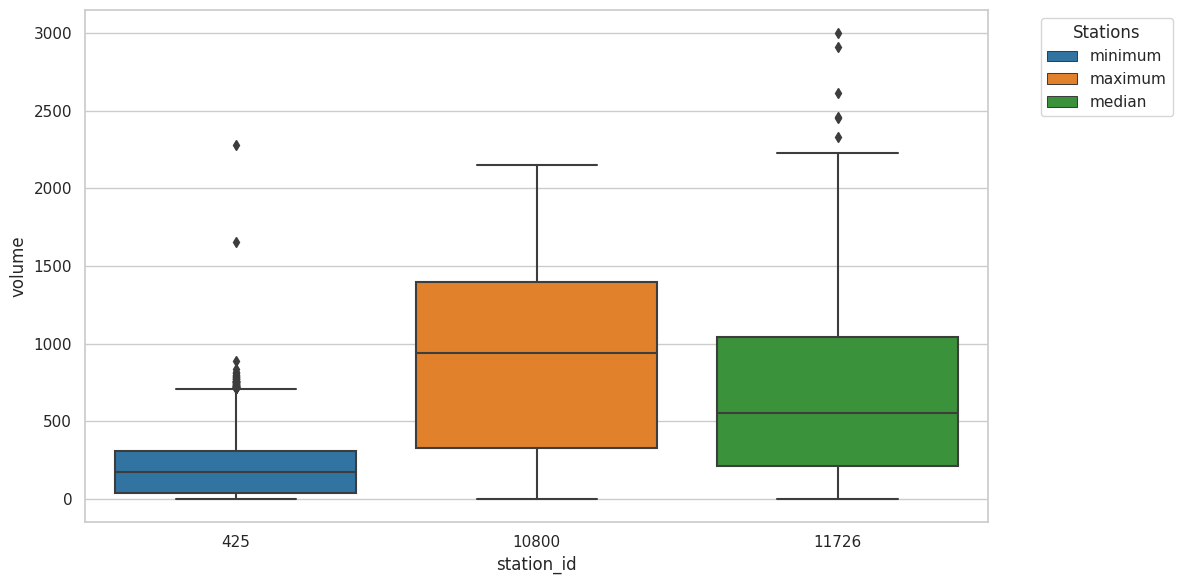

In [34]:
# Now plotting the distribution of volume for these 3 stations
station_box = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=station_df, y='volume', x='station_id', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['minimum', 'maximum', 'median'], title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

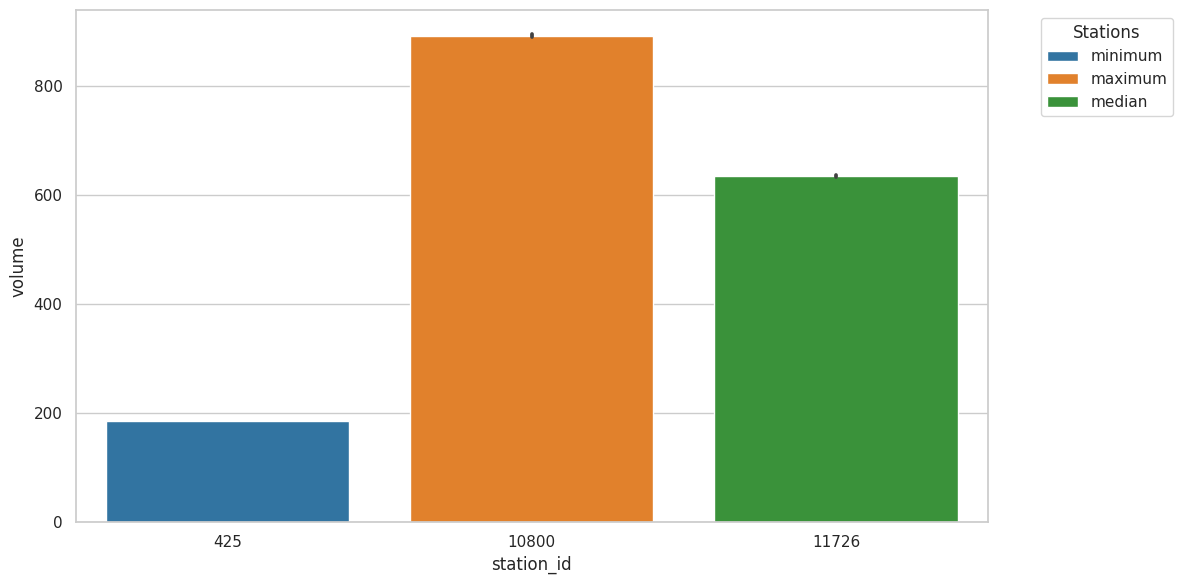

In [35]:
# Now plotting the distribution of volume for these 3 stations
station_bar = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=station_df, y='volume', x='station_id', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['minimum', 'maximum', 'median'], title='Stations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Checking Direction of Travel with Volume

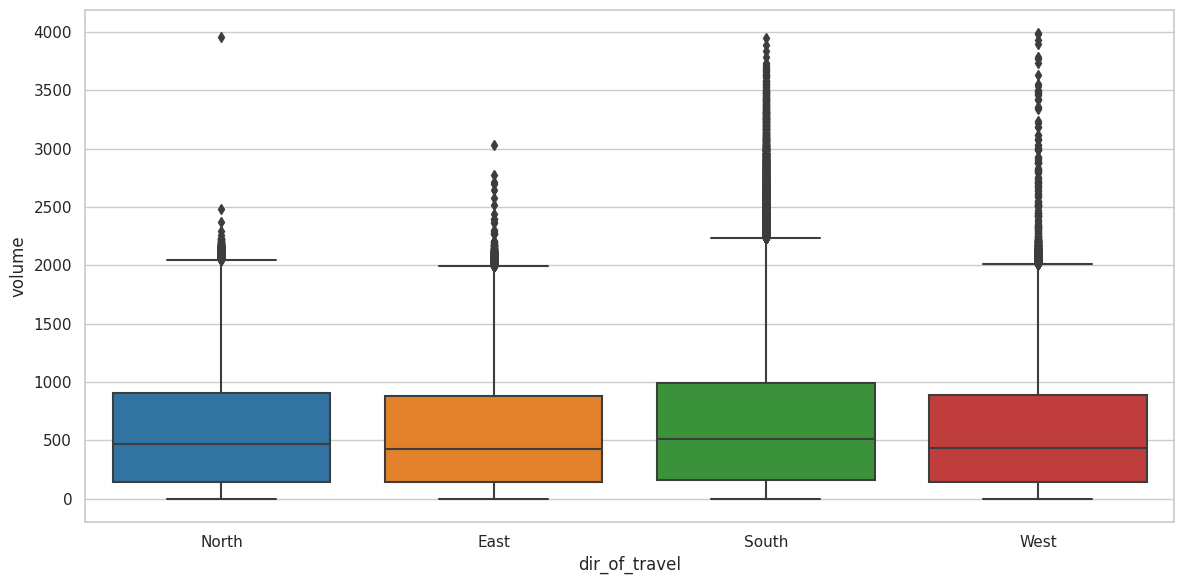

In [36]:
direction_box = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=data, y='volume', x='dir_of_travel', dodge=False)
plt.xticks(ticks=plt.xticks()[0], labels=['North', 'East', 'South', 'West'])
plt.tight_layout()
plt.show()

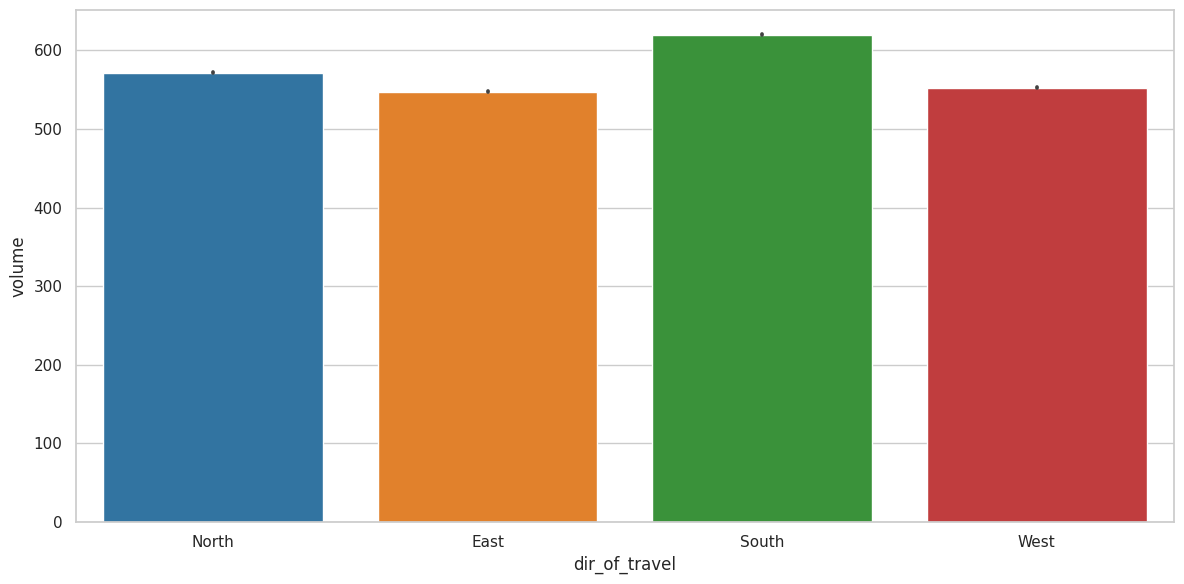

In [37]:
direction_bar = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=data, y='volume', x='dir_of_travel', dodge=False)
plt.xticks(ticks=plt.xticks()[0], labels=['North', 'East', 'South', 'West'])
plt.tight_layout()
plt.show()

### Checking Lanes with Volume

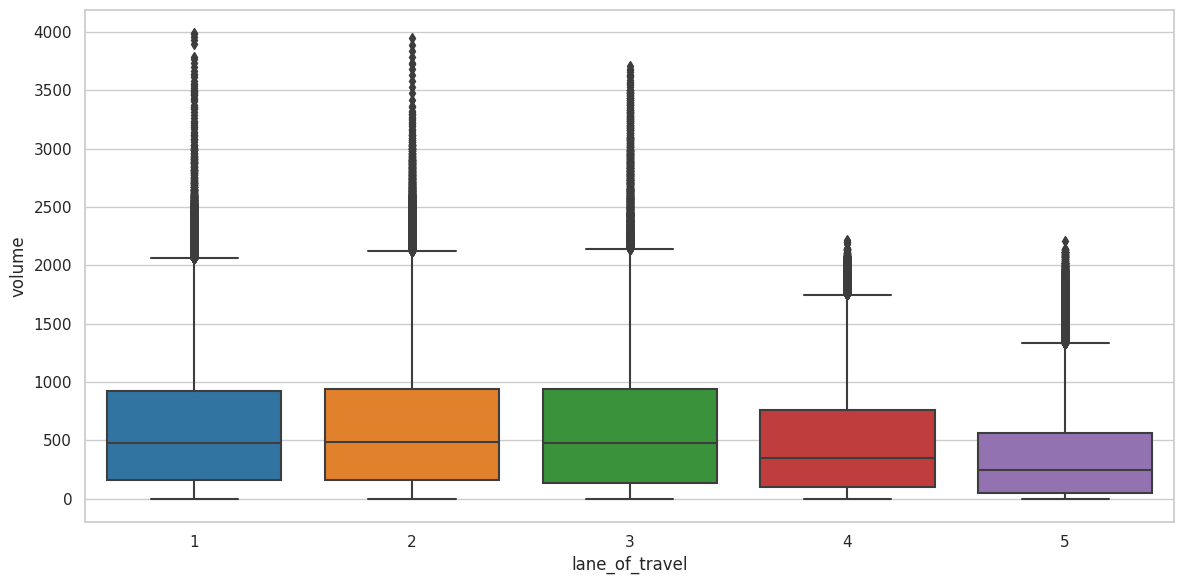

In [38]:
lane_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=data, y='volume', x='lane_of_travel', dodge=False)
plt.tight_layout()
plt.show()

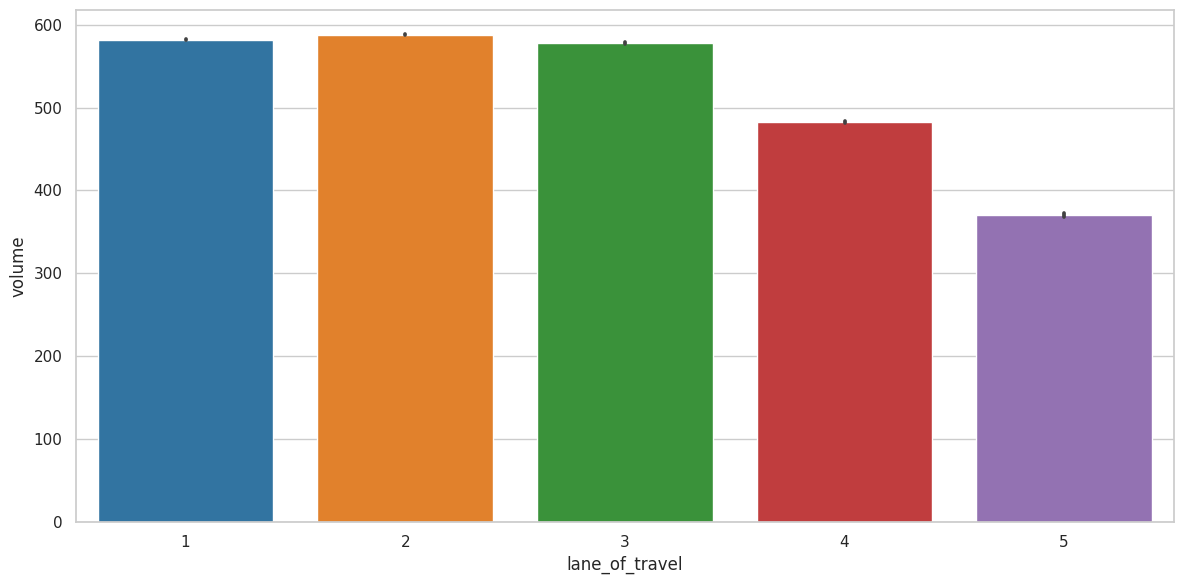

In [39]:
lane_bar = plt.figure(figsize=(12, 6))
sns.barplot(data=data, y='volume', x='lane_of_travel', dodge=False)
plt.tight_layout()
plt.show()

### Checking Holiday with Volume

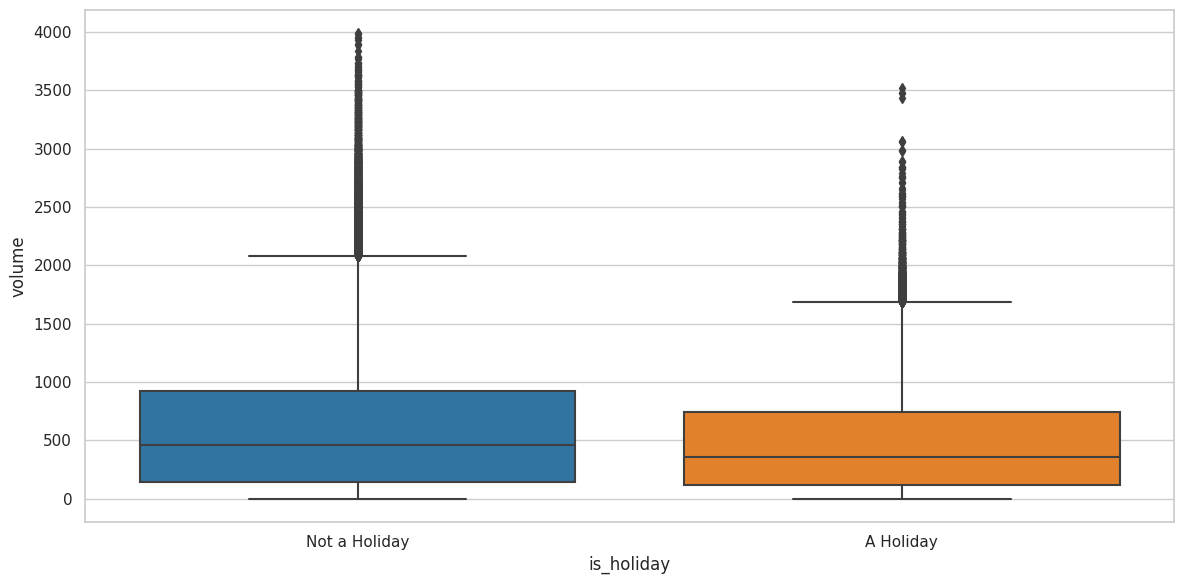

In [40]:
holiday_box = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=data, y='volume', x='is_holiday', dodge=False)
plt.xticks(ticks=[0, 1], labels=['Not a Holiday', 'A Holiday'])
plt.tight_layout()
plt.show()

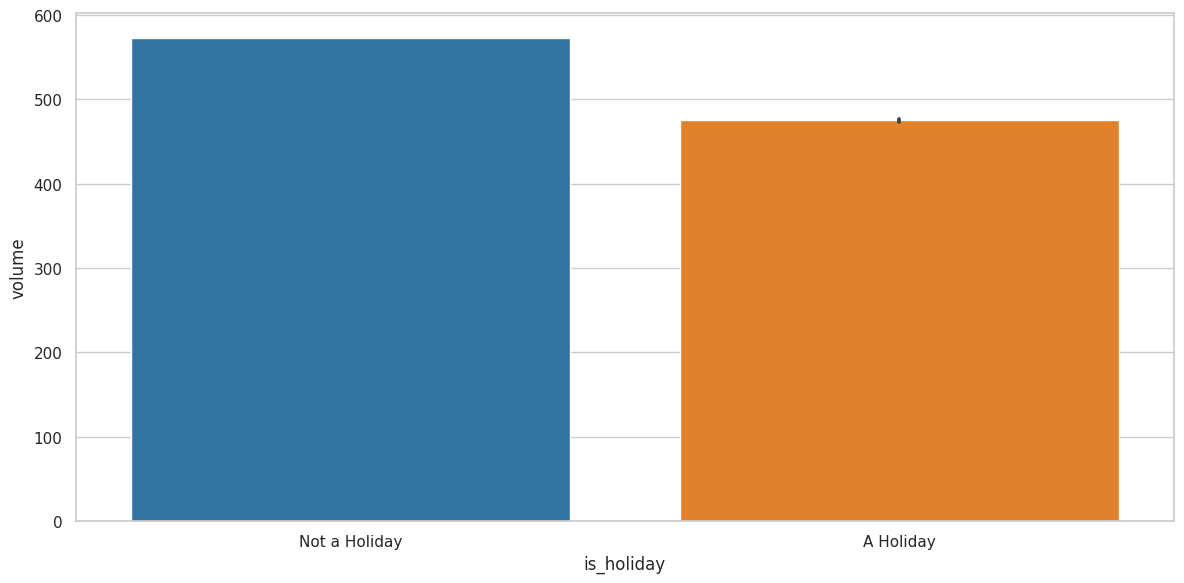

In [41]:
holiday_bar = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=data, y='volume', x='is_holiday', dodge=False)
plt.xticks(ticks=[0, 1], labels=['Not a Holiday', 'A Holiday'])
plt.tight_layout()
plt.show()

### Checking weather with Volume

In [42]:
num_cols = list(data.select_dtypes(include=['int', 'float']).columns)
num_cols

['hour',
 'volume',
 'Maximum Temperature degrees (F)',
 'Minimum Temperature degrees (F)',
 'Precipitation (inches)',
 'Snow (inches)',
 'Snow Depth (inches)',
 'wdir',
 'wspd',
 'pres',
 'is_holiday',
 'day_of_week',
 'day',
 'month',
 'year']

In [43]:
from scipy.stats import shapiro, kstest, spearmanr

# Shapiro-Wilk Test
stat, p_value = shapiro(data.sample(n=2000)['volume'])
print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.9111481308937073, p-value: 1.1055373759269915e-32


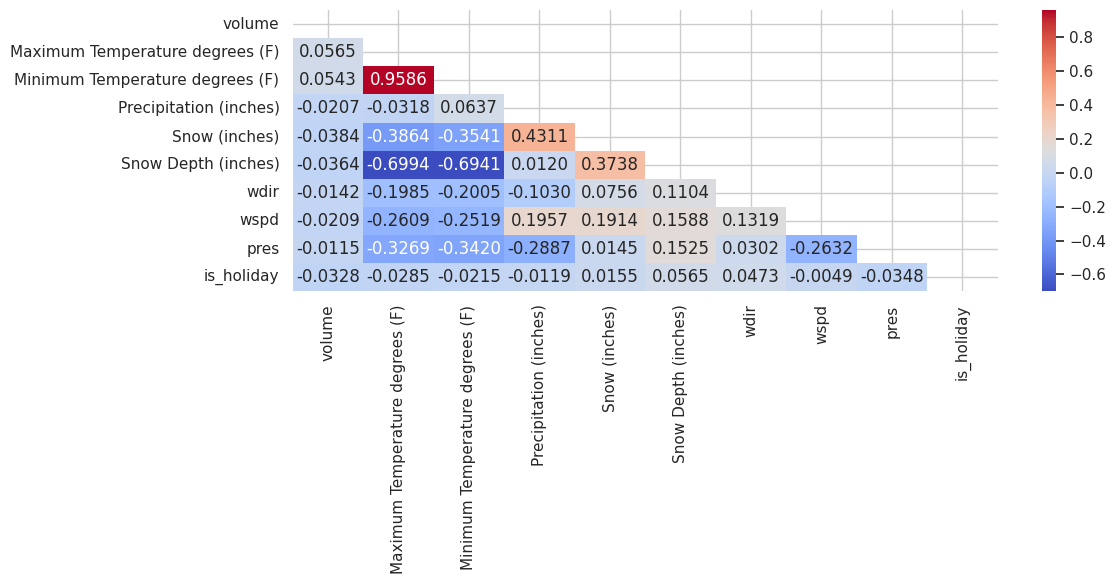

In [44]:
num_cols.remove('hour')
num_cols.remove('day_of_week')
num_cols.remove('day')
num_cols.remove('month')
num_cols.remove('year')

corr = data[num_cols].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_fig = plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4f", cmap='coolwarm')
plt.tight_layout()
plt.show()

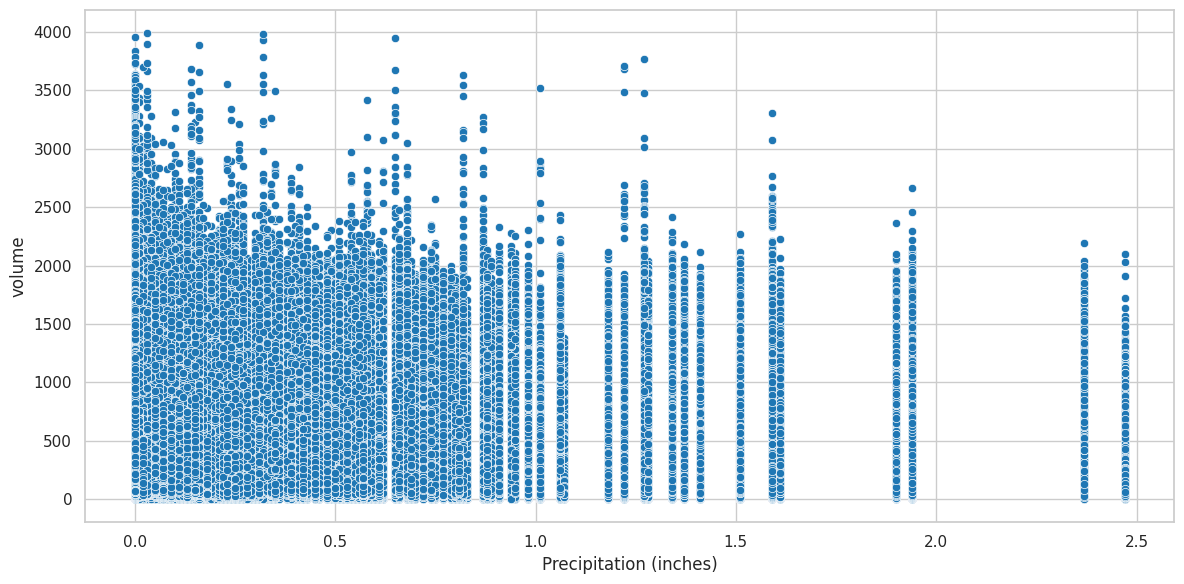

In [45]:
scatter_fig = plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='Precipitation (inches)', y='volume')
plt.tight_layout()
plt.show()

In [46]:
stat, p_value = shapiro(data.sample(n=2000)['Precipitation (inches)'])
print(f'Statistic: {stat}, p-value: {p_value}')

Statistic: 0.3920789361000061, p-value: 0.0


In [47]:
sampled_data = data.sample(n=2000)
corr, p_value = spearmanr(sampled_data['Precipitation (inches)'], sampled_data['volume'])

print(f"Spearman rank correlation coefficient: {corr}, p-value: {p_value}")

Spearman rank correlation coefficient: -0.01701808827549012, p-value: 0.44686535881766576


### Checking Time with Volume

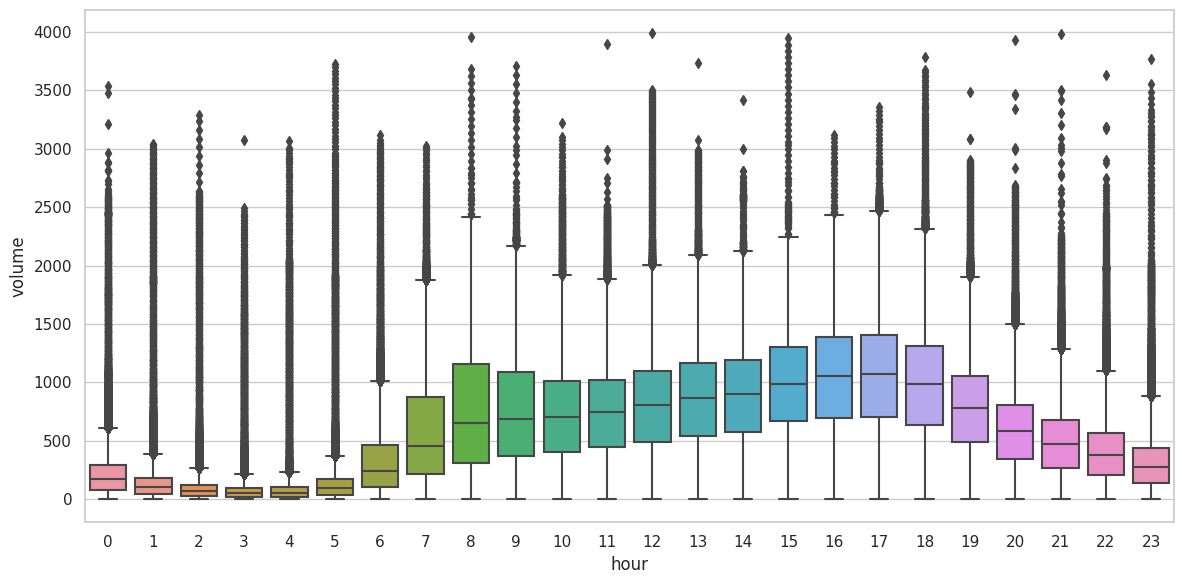

In [48]:
hour_fig_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=data, y='volume', x='hour', dodge=False)
plt.tight_layout()
plt.show()

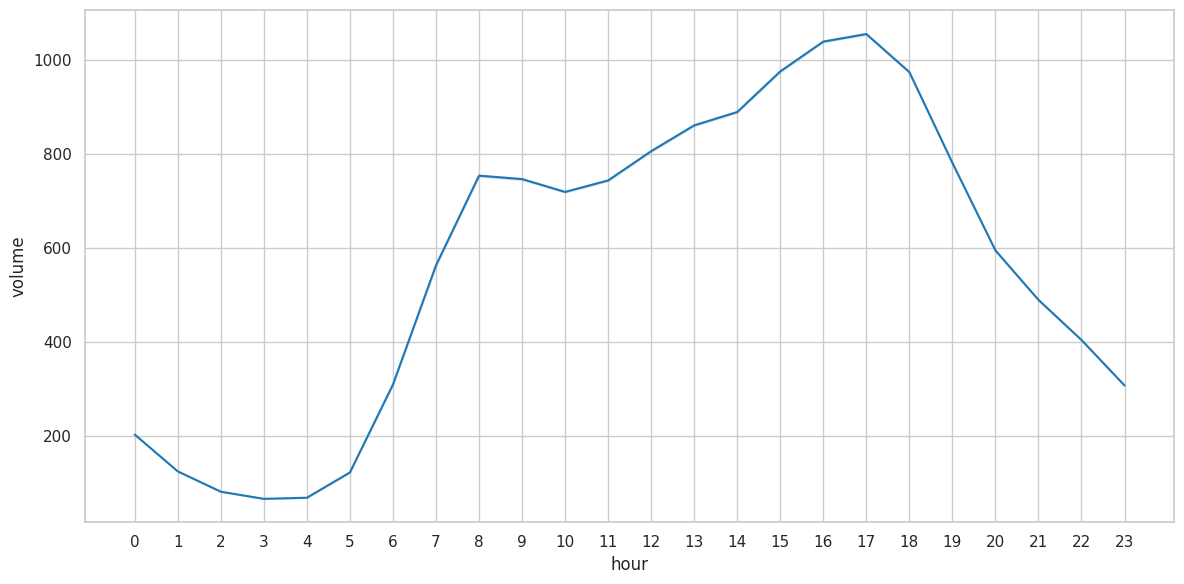

In [49]:
hour_fig_line = plt.figure(figsize=(12, 6))
sns.lineplot(data=data, y='volume', x='hour')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

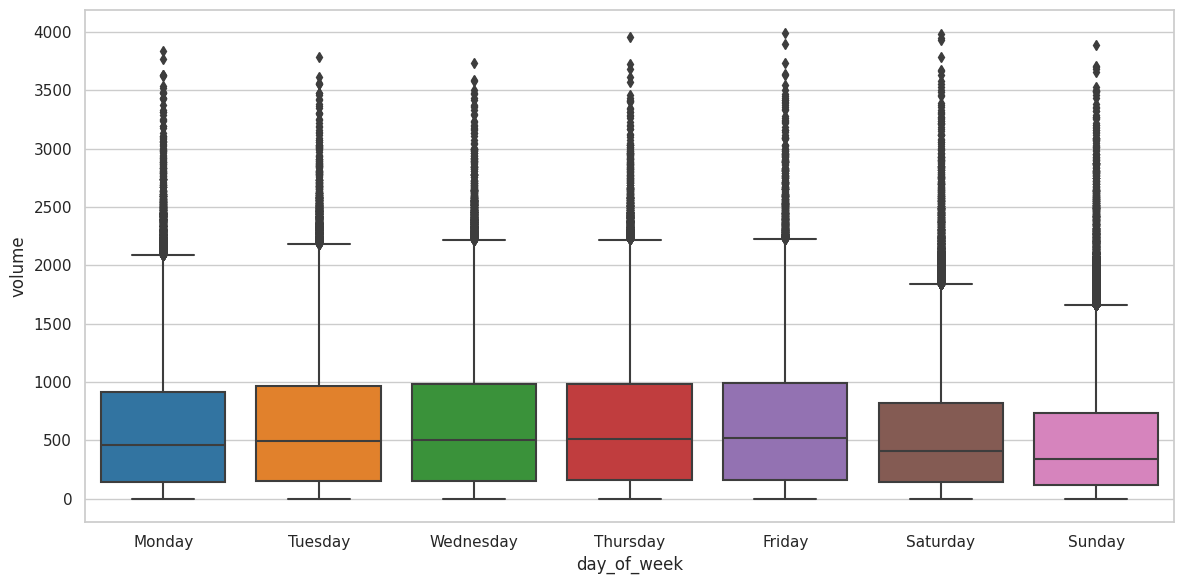

In [50]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_fig_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=data, y='volume', x='day_of_week', dodge=False)
plt.xticks(ticks=range(7), labels=days_of_week)
plt.tight_layout()
plt.show()

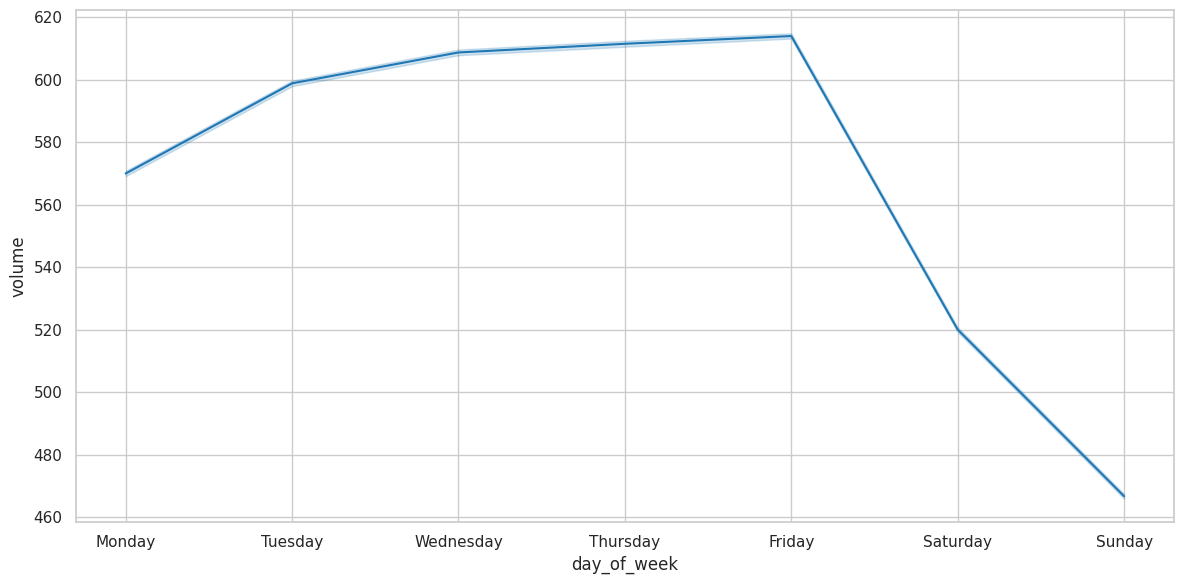

In [51]:
day_fig_line = plt.figure(figsize=(12, 6))
sns.lineplot(data=data, y='volume', x='day_of_week')
plt.xticks(ticks=range(7), labels=days_of_week)
plt.tight_layout()
plt.show()

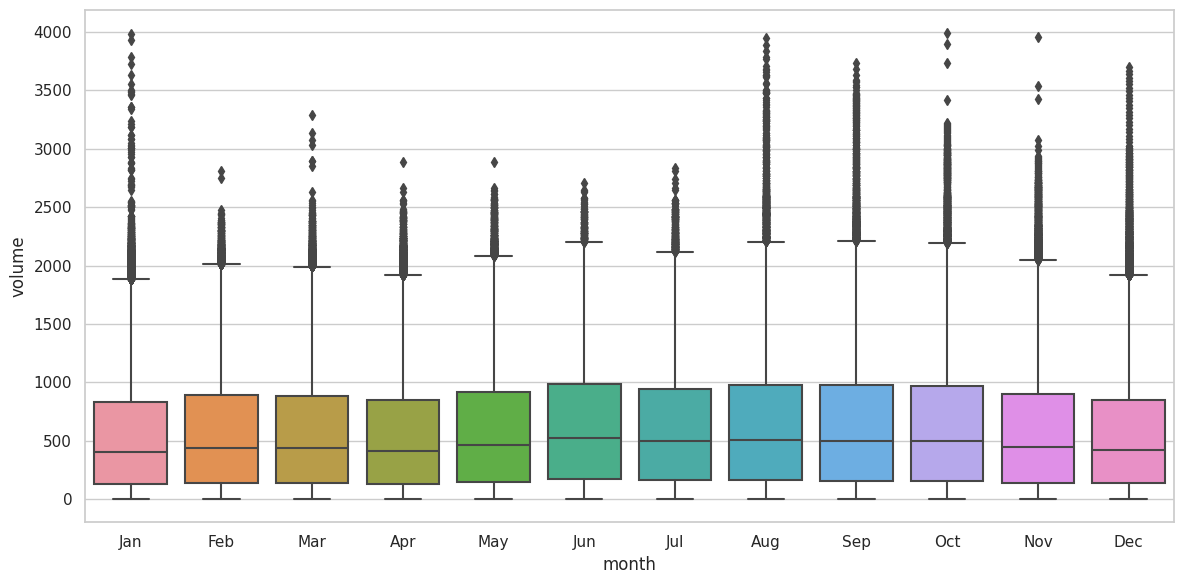

In [52]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_fig_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=data, y='volume', x='month', dodge=False)
plt.xticks(ticks=range(12), labels=months)
plt.tight_layout()
plt.show()

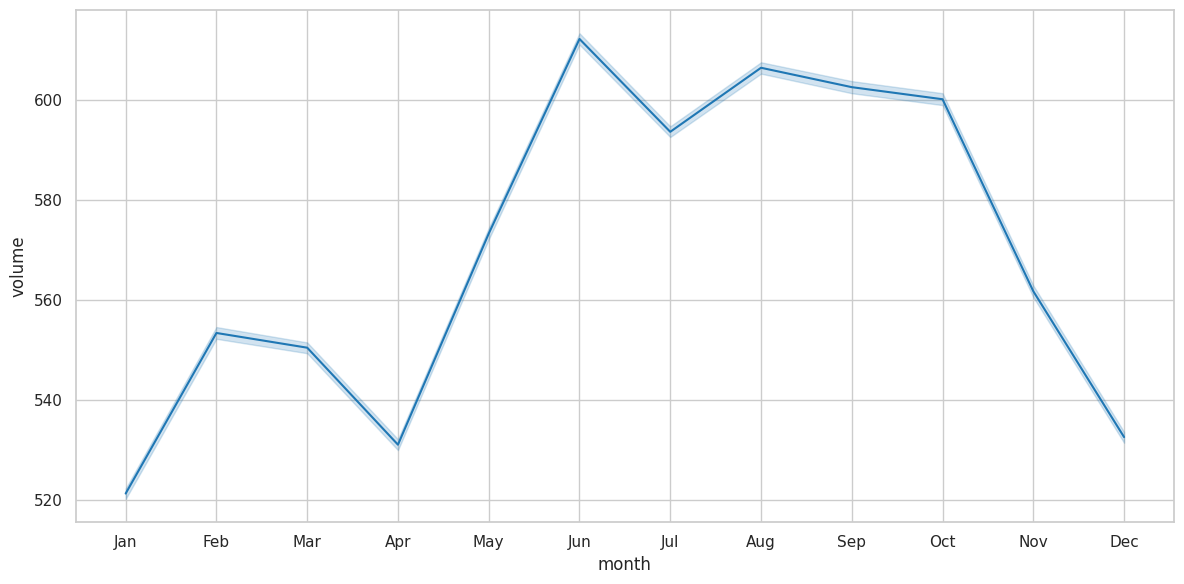

In [53]:
month_fig_line = plt.figure(figsize=(12, 6))
sns.lineplot(data=data, y='volume', x='month')
plt.xticks(ticks=range(1, 13), labels=months)
plt.tight_layout()
plt.show()

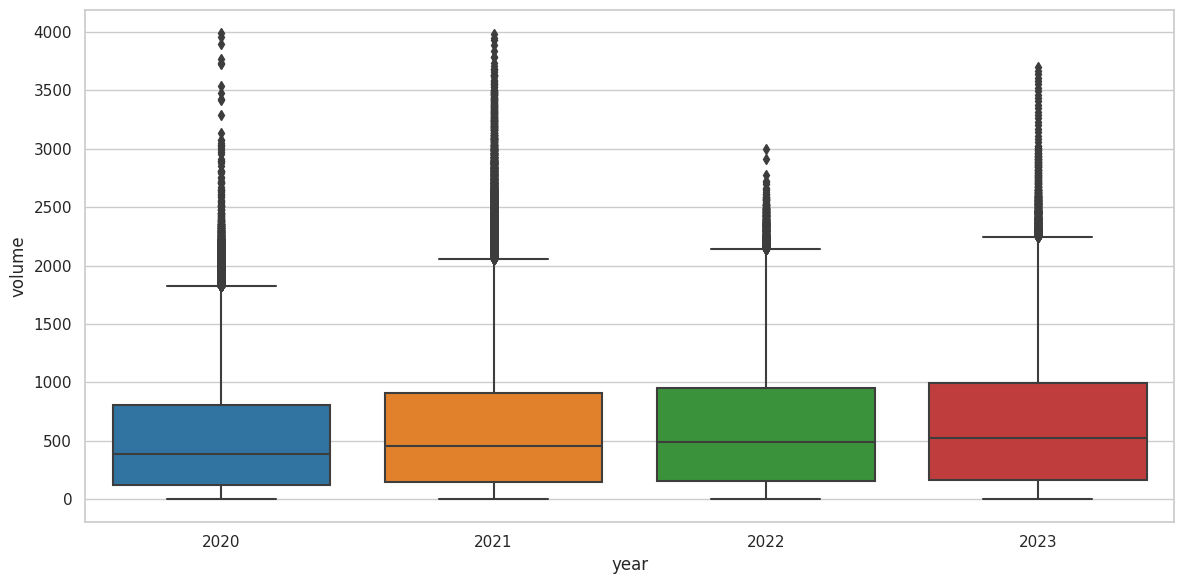

In [54]:
mask_year = data['year']!=2024
year_fig_box = plt.figure(figsize=(12, 6))
sns.boxplot(data=data[mask_year], y='volume', x='year', dodge=False)
plt.tight_layout()
plt.show()

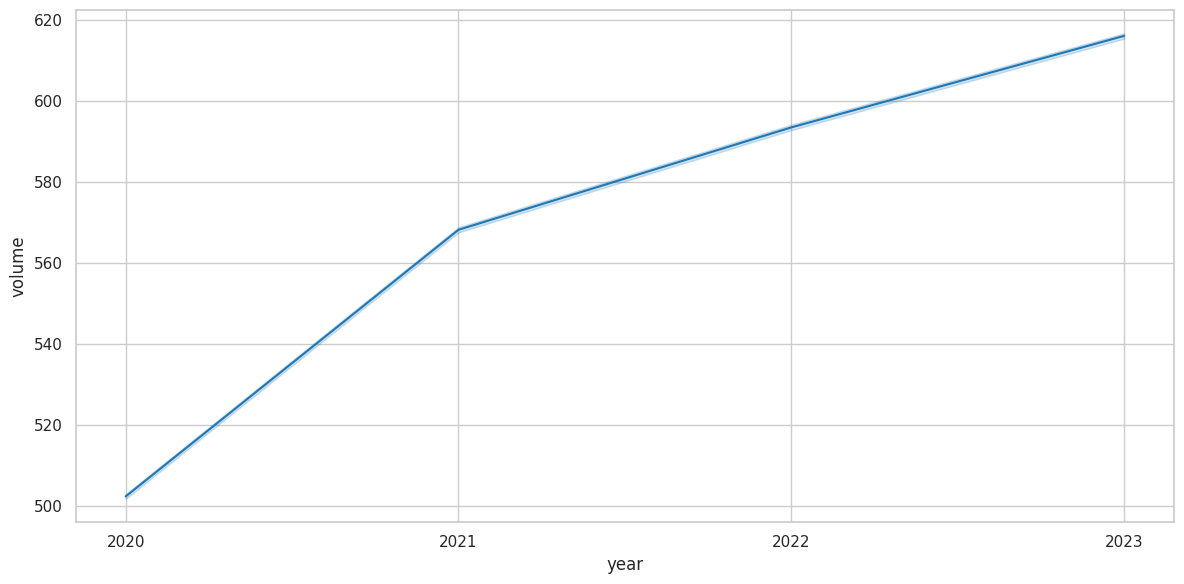

In [55]:
year_fig_line = plt.figure(figsize=(12, 6))
sns.lineplot(data=data[mask_year], y='volume', x='year')
plt.xticks(range(2020, 2024))
plt.tight_layout()
plt.show()

In [56]:
# data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
# data.head()

In [57]:
# mask = (data['year'] == 2020) & (data['month'] == 1) 
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data[mask], x='datetime', y='volume')
# plt.xticks(rotation=90)
# plt.show()

In [58]:
# mask = mask & (data['station_id']==301)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data[mask], x='datetime', y='volume')
# plt.xticks(rotation=90)
# plt.show()

In [59]:
# mask = mask & (data['dir_of_travel']==3)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data[mask], x='datetime', y='volume')
# plt.xticks(rotation=90)
# plt.show()

In [60]:
# mask = mask & (data['lane_of_travel']==1)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data[mask], x='datetime', y='volume')
# plt.xticks(rotation=90)
# plt.show()

In [61]:
# mask = mask & (data['day']==5)
# plt.figure(figsize=(12, 6))
# sns.lineplot(data=data[mask], x='datetime', y='volume')
# plt.xticks(rotation=90)
# plt.show()

### Comparing stations with different lanes

In [62]:
# Getting the number of lanes for each station
num_lanes_per_station = data.groupby('station_id')['lane_of_travel'].nunique().reset_index()

# # Selecting one from each
# mask = num_lanes_per_station['lane_of_travel']==2
# station_2_lane = np.random.choice(num_lanes_per_station.loc[mask, 'station_id'].unique())

# mask = num_lanes_per_station['lane_of_travel']==3
# station_3_lane = np.random.choice(num_lanes_per_station.loc[mask, 'station_id'].unique())

# mask = num_lanes_per_station['lane_of_travel']==4
# station_4_lane = np.random.choice(num_lanes_per_station.loc[mask, 'station_id'].unique())

# mask = num_lanes_per_station['lane_of_travel']==5
# station_5_lane = np.random.choice(num_lanes_per_station.loc[mask, 'station_id'].unique())

In [63]:
# station_2_lane, station_3_lane, station_4_lane, station_5_lane

In [64]:
station_2_lane = 42507
station_3_lane = 11747
station_4_lane = 11517
station_5_lane = 11179

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


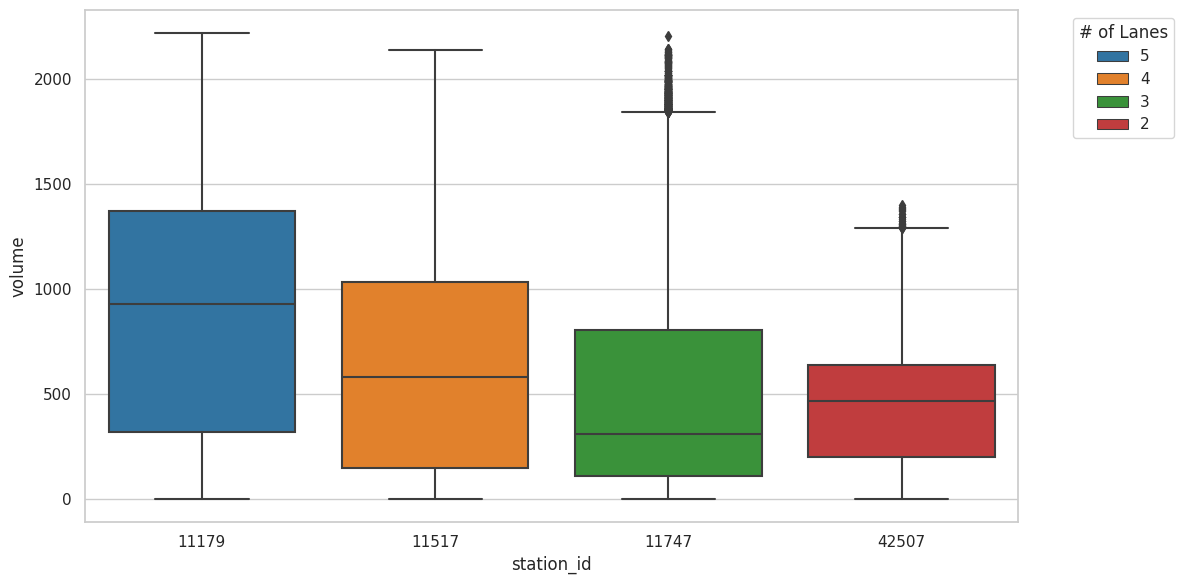

In [65]:
stations_lanes_mask = data['station_id'].isin([station_2_lane, station_3_lane, station_4_lane, station_5_lane])
stations_lanes = data[stations_lanes_mask]
stations_lanes['station_id'] = stations_lanes['station_id'].astype('object')

num_lanes_box = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=stations_lanes, x='station_id', y='volume', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['5', '4', '3', '2'], title='# of Lanes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

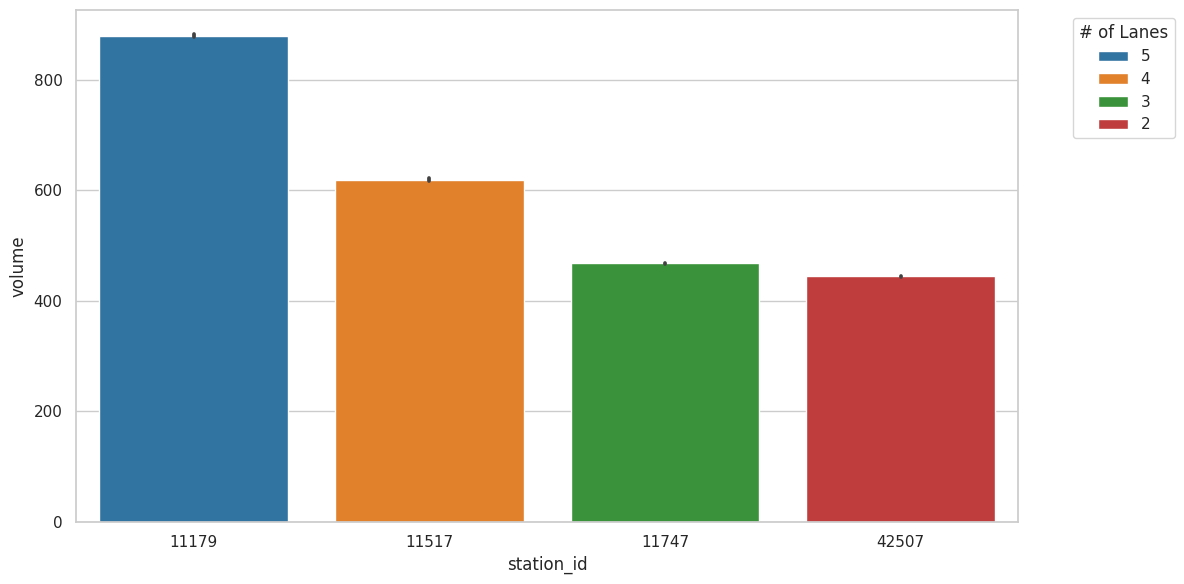

In [66]:
num_lanes_bar = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=stations_lanes, x='station_id', y='volume', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['5', '4', '3', '2'], title='# of Lanes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Comparing the center area with outskirts 

In [67]:
# Looking at the center's lane count
mask = num_lanes_per_station['station_id']==10800
lane_10800_count = num_lanes_per_station.loc[mask, 'lane_of_travel'].values[0]
lane_10800_count

3

In [68]:
# # Selecting at a station with similar lane count
# mask = num_lanes_per_station['lane_of_travel']==lane_10800_count
# choices = list(num_lanes_per_station.loc[mask, 'station_id'].unique())
# choices.remove(10800)
# choices

In [69]:
station_lane_10800_count = 10390
# station_lane_10800_count = 11464
station_lane_10800_count

10390

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


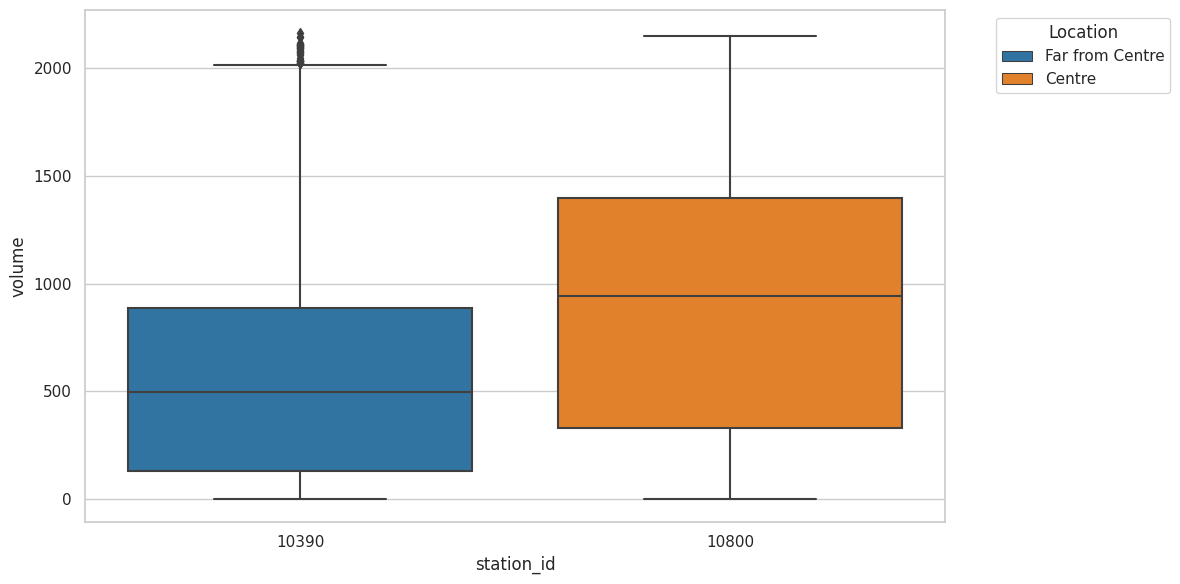

In [70]:
comparing_stations_mask = data['station_id'].isin([station_lane_10800_count, 10800])
comparing_stations = data[comparing_stations_mask]
comparing_stations['station_id'] = comparing_stations['station_id'].astype('object')

center_box = plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=comparing_stations, x='station_id', y='volume', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Far from Centre', 'Centre'], title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

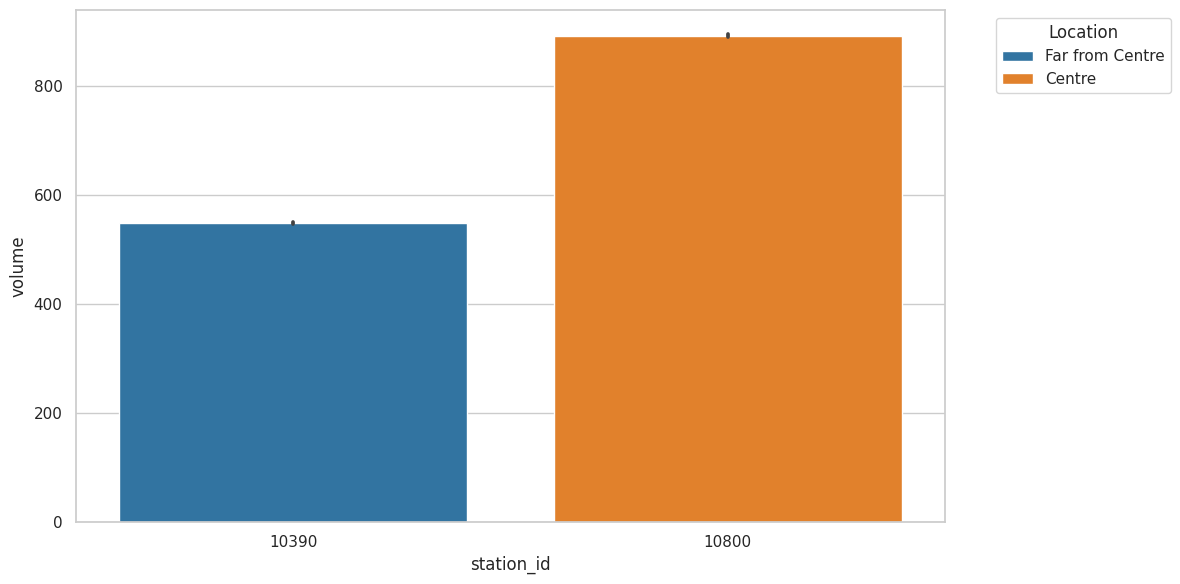

In [71]:
center_bar = plt.figure(figsize=(12, 6))
ax = sns.barplot(data=comparing_stations, x='station_id', y='volume', hue='station_id', dodge=False)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Far from Centre', 'Centre'], title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [72]:
# # Looking at the center's lane count
# mask = num_lanes_per_station['station_id']==301
# lane_301_count = num_lanes_per_station.loc[mask, 'lane_of_travel'].values[0]
# lane_301_count

In [73]:
# # Selecting at a station with similar lane count
# mask = num_lanes_per_station['lane_of_travel']==lane_301_count
# choices = list(num_lanes_per_station.loc[mask, 'station_id'].unique())
# choices.remove(301)
# choices

In [74]:
# station_lane_301_count = 11280
# station_lane_301_count

In [75]:
# comparing_stations_mask = data['station_id'].isin([station_lane_301_count, 301])
# comparing_stations = data[comparing_stations_mask]
# comparing_stations['station_id'] = comparing_stations['station_id'].astype('object')

# sns.boxplot(data=comparing_stations, x='station_id', y='volume')
# plt.show()

evaluation for 4 models

In [76]:
eval_xgb_path = '/kaggle/input/traffic-trained-models/Traffic Volume Forecasting/XGBoost/xgboost'
eval_lstm_path = '/kaggle/input/traffic-trained-models/Traffic Volume Forecasting/LSTM/units 16/batch size 64/Dense 3/lstm_1'
eval_gru_path = '/kaggle/input/traffic-trained-models/Traffic Volume Forecasting/GRU/units 16/batch size 128/Dense 3/gru_1'
eval_convlstm_path = '/kaggle/input/traffic-trained-models/Traffic Volume Forecasting/ConvLSTM/units 64/batch size 256/Dense 5/convlstm_1'

In [77]:
import pickle 
with open(eval_xgb_path, "rb") as file_pi:
    eval_xgb = pickle.load(file_pi)

with open(eval_lstm_path, "rb") as file_pi:
    eval_lstm = pickle.load(file_pi)

with open(eval_gru_path, "rb") as file_pi:
    eval_gru = pickle.load(file_pi)

with open(eval_convlstm_path, "rb") as file_pi:
    eval_convlstm = pickle.load(file_pi)

In [78]:
eval_xgb_train = pd.DataFrame(eval_xgb['train'])
eval_xgb_valid = pd.DataFrame(eval_xgb['validation'])

In [79]:
eval_xgb_train['mse'] = eval_xgb_train['rmse']**2
eval_xgb_valid['mse'] = eval_xgb_valid['rmse']**2

In [80]:
loss = {}
loss['mse'] = eval_lstm['loss']
loss['mae'] = eval_lstm['mae']
eval_lstm_train = pd.DataFrame(loss)

loss = {}
loss['mse'] = eval_lstm['val_loss']
loss['mae'] = eval_lstm['val_mae']
eval_lstm_valid = pd.DataFrame(loss)

In [81]:
loss = {}
loss['mse'] = eval_gru['loss']
loss['mae'] = eval_gru['mae']
eval_gru_train = pd.DataFrame(loss)

loss = {}
loss['mse'] = eval_gru['val_loss']
loss['mae'] = eval_gru['val_mae']
eval_gru_valid = pd.DataFrame(loss)

In [82]:
loss = {}
loss['mse'] = eval_convlstm['loss']
loss['mae'] = eval_convlstm['mae']
eval_convlstm_train = pd.DataFrame(loss)

loss = {}
loss['mse'] = eval_convlstm['val_loss']
loss['mae'] = eval_convlstm['val_mae']
eval_convlstm_valid = pd.DataFrame(loss)

In [83]:
eval_xgb_train

,rmse,mae,mse
0,338.130196,282.522290,114332.029255
1,248.740197,205.148136,61871.685821
2,189.163769,152.873916,35782.931631
3,150.937941,118.075444,22782.262098
4,127.074642,95.203418,16147.964607
...,...,...,...
95,75.734210,46.957571,5735.670591
96,75.670844,46.904545,5726.076661
97,75.590383,46.845319,5713.906000
98,75.497838,46.816630,5699.923473


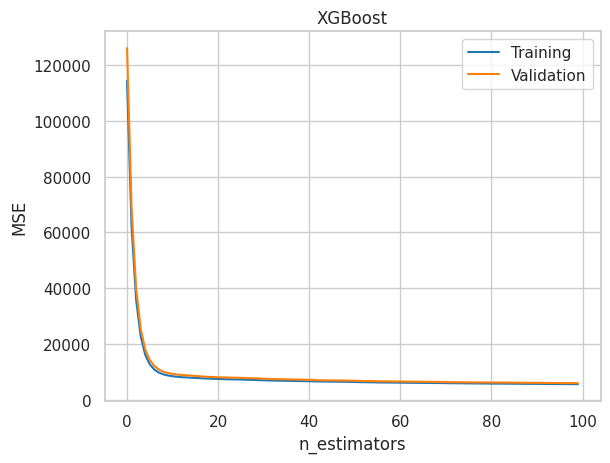

In [84]:
plt.plot(eval_xgb_train['mse'], label='Training')
plt.plot(eval_xgb_valid['mse'], label='Validation')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('XGBoost')
plt.show()

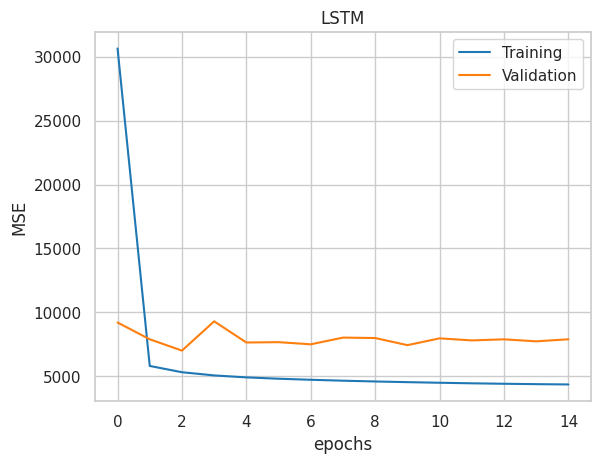

In [85]:
plt.plot(eval_lstm_train['mse'], label='Training')
plt.plot(eval_lstm_valid['mse'], label='Validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('LSTM')
plt.show()

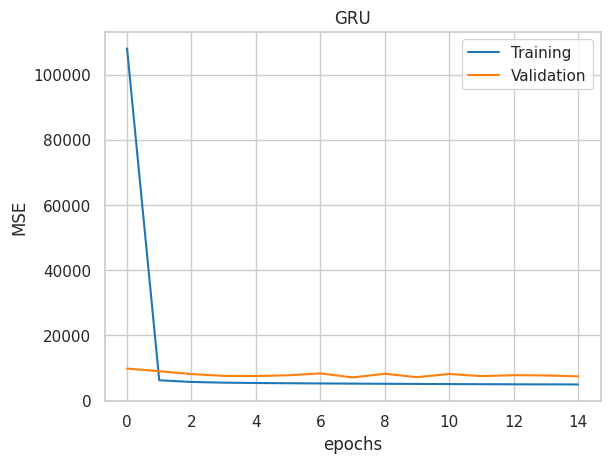

In [86]:
plt.plot(eval_gru_train['mse'], label='Training')
plt.plot(eval_gru_valid['mse'], label='Validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('GRU')
plt.show()

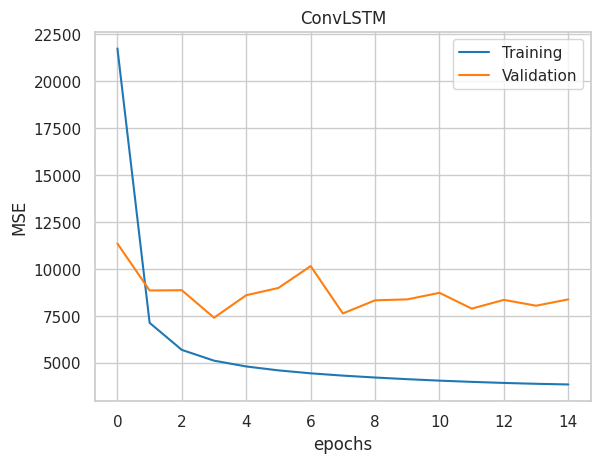

In [87]:
plt.plot(eval_convlstm_train['mse'], label='Training')
plt.plot(eval_convlstm_valid['mse'], label='Validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('ConvLSTM')
plt.show()

## Creating Variables for Dash

In [88]:
month_dict = {'Jan':1,
             'Feb':2,
             'Mar':3,
             'Apr':4,
             'May':5,
             'Jun':6,
             'Jul':7,
             'Aug':8,
             'Sep':9,
             'Oct':10,
             'Nov':11,
             'Dec':12}

In [89]:
selection_data = data.groupby(['station_id', 'dir_of_travel', 'lane_of_travel'])['volume'].sum()
selection_data = selection_data[selection_data>0].reset_index().drop('volume', axis=1)
selection_data['station_id'] = selection_data['station_id'].astype('object')
selection_data['dir_of_travel'] = selection_data['dir_of_travel'].astype('object')
selection_data['lane_of_travel'] = selection_data['lane_of_travel'].astype('object')
selection_data.head(5)

,station_id,dir_of_travel,lane_of_travel
0,301,3,1
1,301,3,2
2,301,3,3
3,301,3,4
4,301,7,1


In [90]:
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data.head()

,station_id,dir_of_travel,lane_of_travel,date,hour,volume,Maximum Temperature degrees (F),Minimum Temperature degrees (F),Precipitation (inches),Snow (inches),...,wdir,wspd,pres,is_holiday,day_of_week,day,week,month,year,datetime
0,301,3,1,2020-01-03,0,315,37.0,31.0,0.00,0.0,...,272.0,19.1,1000.8,0,4,3,1,1,2020,2020-01-03
1,301,3,1,2020-01-04,0,385,36.0,24.0,0.00,0.0,...,238.0,12.6,1011.7,0,5,4,1,1,2020,2020-01-04
2,301,3,1,2020-01-05,0,404,30.0,24.0,0.00,0.0,...,226.0,15.9,1018.9,0,6,5,1,1,2020,2020-01-05
3,301,3,1,2020-01-06,0,221,38.0,24.0,0.01,0.0,...,274.0,28.5,1014.9,0,0,6,2,1,2020,2020-01-06
4,301,3,1,2020-01-07,0,279,36.0,22.0,0.00,0.0,...,231.0,18.2,1019.3,0,1,7,2,1,2020,2020-01-07


In [91]:
eval_results_path = '/kaggle/input/eval-traffic-volume/Models volume traffic forecasting.xlsx'
eval_dl_results = pd.read_excel(eval_results_path, sheet_name='No dropout or regularisation', header=1).iloc[:42]
eval_dl_results.rename(columns={'Training R2 score': 'Training R2 Score'}, inplace=True)
eval_dl_results

,Model,Units,Batch Size,Dense Layers,Cosine Decay Warmup Time,Training mse,Validation mse,Training mae,Validation mae,Training R2 Score,Validation R2 Score,Overfitting
0,LSTM,4.0,128.0,1.0,2 epochs,6695.0571,9467.9658,50.5498,66.6394,0.9696,0.9605,Yes
1,LSTM,4.0,256.0,1.0,2 epochs,6654.2964,9270.2070,50.9482,66.6682,0.9697,0.9613,Yes
2,LSTM,8.0,64.0,2.0,2 epochs,5608.2168,8466.6592,46.2514,63.2117,0.9745,0.9646,Yes
3,LSTM,8.0,128.0,2.0,2 epochs,5599.2236,8249.3047,45.9460,62.7765,0.9746,0.9655,Yes
4,LSTM,8.0,256.0,2.0,2 epochs,5565.1504,8367.2852,45.9579,62.9814,0.9747,0.9651,Yes
5,LSTM,16.0,64.0,3.0,2 epochs,4340.6000,7890.2217,40.4180,61.6722,0.9803,0.9670,Yes
6,LSTM,16.0,128.0,3.0,2 epochs,4482.7183,7971.1709,41.0272,61.6757,0.9796,0.9667,Yes
7,LSTM,16.0,256.0,0.0,2 epochs,4614.9185,7974.1733,41.8042,61.5766,0.9790,0.9667,Yes
8,LSTM,16.0,256.0,3.0,2 epochs,4717.6421,8339.6338,42.3157,63.2721,0.9786,0.9652,Yes
9,LSTM,32.0,64.0,4.0,2 epochs,3720.1860,8060.7090,36.9785,61.8147,0.9831,0.9663,Yes


In [92]:
eval_dl_nw_results = pd.read_excel(eval_results_path, sheet_name='No dropout or regularisation', header=1).iloc[[52]].reset_index(drop=True)
eval_dl_nw_results = pd.concat([eval_dl_nw_results, eval_dl_results.iloc[[16]]])
eval_dl_nw_results['Weather'] = ['No', 'Yes']
eval_dl_nw_results.reset_index(drop=True, inplace=True)
eval_dl_nw_results

,Model,Units,Batch Size,Dense Layers,Cosine Decay Warmup Time,Training mse,Validation mse,Training mae,Validation mae,Training R2 score,Validation R2 Score,Overfitting,Training R2 Score,Weather
0,LSTM,32.0,256.0,4.0,2 epochs,3903.9011,8222.2070,37.7626,62.5794,0.9822,0.9657,Yes,NaN,No
1,LSTM,32.0,256.0,4.0,2 epochs,3768.7119,8255.5811,37.3308,61.9293,NaN,0.9655,Yes,0.9829,Yes


In [93]:
eval_lr_results = pd.read_excel(eval_results_path, sheet_name='Learning Rate Trial', header=None)
eval_lr_results.columns = ['Model', 'Units', 'Batch Size', 'Learning Rate', 'Cosine Decay', 'Training mse',
                          'Validation mse', 'Training mae', 'Validation mae', 'Training R2 Score', 'Validation R2 Score',
                          'Overfitting']
eval_lr_results

,Model,Units,Batch Size,Learning Rate,Cosine Decay,Training mse,Validation mse,Training mae,Validation mae,Training R2 Score,Validation R2 Score,Overfitting
0,GRU,32,256,0.0010,2 epochs,3948.9341,7846.0957,38.1863,60.3668,0.9821,0.9672,Yes
1,GRU,32,256,0.0001,2 epochs,5240.4751,8124.4199,43.9662,61.6592,0.9762,0.9661,Yes
2,GRU,32,256,0.0003,2 epochs,4421.9169,8322.3457,40.5982,62.7607,0.9799,0.9652,Yes
3,GRU,32,256,0.0010,1 epochs,3934.0112,7729.9585,38.3400,60.3044,0.9821,0.9677,Yes
4,GRU,32,256,0.0010,0.5 epochs,4646.3193,8473.7773,41.5090,62.5904,0.9789,0.9646,Yes
5,GRU,32,256,0.0010,no decay,4107.1748,8059.8794,39.3402,60.7001,0.9813,0.9663,Yes


In [94]:
eval_ts_results = pd.read_excel(eval_results_path, sheet_name='TimeSteps')
eval_ts_results

,Timesteps,Lags,Model,Units,Batch Size,Cosine Decay Warmup,Training mse,Validation mse,Training mae,Validation mae,Training R2 score,Validation R2 Score,Overfitting
0,3,1,GRU,32,256,2 epochs,3948.9341,7846.0957,38.1863,60.3668,0.9821,0.9672,Yes
1,1,3,GRU,32,256,2 epochs,4690.3569,8154.9995,41.7478,61.3972,0.9787,0.9659,Yes


In [95]:
eval_xgb_pca_results = pd.read_excel(eval_results_path, sheet_name='Xgboost')
eval_xgb_pca_results.rename(columns={'Training R2' : 'Training R2 Score',
                            'Validation R2' : 'Validation R2 Score'}, inplace=True)
eval_xgb_pca_results

,Model,PCA,Training mse,Validation mse,Training mae,Validation mae,Training R2 Score,Validation R2 Score,Overfitting
0,XGBoost,No,5685.959268,6104.101577,46.7350,50.4537,0.9741,0.9745,No
1,XGBoost,Yes,5691.072897,6069.407161,46.7502,50.3497,0.9741,0.9746,No


In [96]:
eval_comparison_results = pd.concat([eval_dl_results.iloc[[5, 35, 40], [0, 5, 6, 7, 8, 9, 10, 11]], 
                                     eval_xgb_pca_results.iloc[[1], [0, 2, 3, 4, 5, 6, 7, 8]]],
                                   ignore_index=True)
eval_comparison_results

,Model,Training mse,Validation mse,Training mae,Validation mae,Training R2 Score,Validation R2 Score,Overfitting
0,LSTM,4340.600000,7890.221700,40.4180,61.6722,0.9803,0.9670,Yes
1,GRU,3948.934100,7846.095700,38.1863,60.3668,0.9821,0.9672,Yes
2,ConvLSTM,3855.790800,8376.537100,38.5331,63.4407,0.9825,0.9650,Yes
3,XGBoost,5691.072897,6069.407161,46.7502,50.3497,0.9741,0.9746,No


In [97]:
max_volume = data['volume'].max()

In [98]:
global yolo, tracker
yolo = YOLO('yolov8x.pt')
tracker = sv.ByteTrack()

100%|██████████| 131M/131M [00:00<00:00, 258MB/s] 


In [99]:
model_path = '/kaggle/input/traffic-trained-models/Traffic Volume Forecasting/XGBoost/xgb_final.json'
custom_objects = {'mae': MAE}

global xgb
xgb = XGBRegressor()
xgb.load_model(model_path)

In [100]:
global comparison_path, past_v
comparison_path = None
past_v = None

In [101]:
end_time = time.time()
minutes = (end_time - start_time)//60
end_time - start_time 

1249.3562593460083

In [102]:
minutes

20.0

## Creating the Dash Components

In [103]:
welcome_tab = dbc.Tab(id='welcome', label='Welcome',
                     children=[
                         dbc.Card(dbc.CardBody([dcc.Markdown('''
                         ### Welcome to the Project Dashboard Bolaaaaaa! 😏😂🙏

                        This dashboard allows you to explore the data behind the project, experiment with forecasting techniques, and apply my final predictive model. 

                        #### Key Features:
                        - **Data Exploration**: Dive into the datasets used in this project, with options to filter and visualize key trends.
                        - **Forecasting Models**: Test different forecasting methods and compare their performance.
                        - **Video Model Application**: Learn how our final model can be applied directly to video footage for real-time analysis.
                    ''')]))
                     ])

In [104]:
data_analysis_tab = dbc.Tab(id='da-tab', label='Data Analysis',
                           children=[
                               html.Br(),
                               dbc.Card(
                                 dbc.CardBody([
                                     dbc.Row([
                                         dbc.Col(
                                             dcc.Dropdown(id='da-dropdown', 
                                                         options=['Boxplot', 'Barplot'],
                                                         placeholder='Select the Visualisation Type'),
                                         )
                                     ])
                                 ])
                             ),

                             html.Br(),
                             dcc.Loading(html.Div(id='da-fig'))
                           ])

In [105]:
lane_area_tab = dbc.Tab(id='lane-area-tab', label='Spatial Location Impact',
                       children=[
                           dbc.Card(dbc.CardBody([html.H3("RQ1: How does the number of lanes impact the vehicle count within the road? "),
                           html.H3("RQ2: Does the traffic congestion increase more in the centre of an area/city compared to the rest of the city? ")])),
                           html.Br(),
                           dbc.Card(
                             dbc.CardBody([
                                 dbc.Row([
                                     dbc.Col(
                                         dcc.Dropdown(id='lane-area-dropdown', 
                                                     options=['Boxplot', 'Barplot'],
                                                     placeholder='Select the Visualisation Type'),
                                     )
                                 ])
                             ])
                         ),
                         
                         html.Br(),
                         dcc.Loading(html.Div(id='lane-area-fig'))
                       ])

In [106]:
weather_tab = dbc.Tab(id='weather-tab', label='Weather',
                     children=[
                         dbc.Card(dbc.CardBody([html.H3("RQ3: How does the weather impact the traffic flow and the number of vehicles in an area?")])),
                         html.Br(),
                         dbc.Card(
                             dbc.CardBody([
                                 dbc.Row([
                                     dbc.Col(
                                         dcc.Dropdown(id='weather-dropdown', 
                                                     options=['Correlation', 'Scatterplot'],
                                                     placeholder='Select the Visualisation Type'),
                                     )
                                 ])
                             ])
                         ),
                         
                         html.Br(),
                         dcc.Loading(html.Div(id='weather-fig'))
                     ])

In [107]:
time_tab = dbc.Tab(id='time-tab', label='Time Series',
                  children=[
                      html.Br(),
                      dbc.Card(
                          dbc.CardBody([
                              dbc.Row([
                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("Road Selector"),
                                          dcc.Dropdown(id='station-time',
                                                  options=list(selection_data['station_id'].unique()),
                                                  placeholder="Select a Station...")])
                                  , width=2),

                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("1:North, 3:East, 5:South, 7:West"),
                                          dcc.Dropdown(id='direction-time',
                                                  options=list(selection_data['dir_of_travel'].unique()),
                                                  placeholder="Select a Direction...")
                                      ])
                                  , width=2),

                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("1 : rightmost lane"),
                                          dcc.Dropdown(id='lane-time',
                                                  options=['All Lanes'] + list(selection_data['lane_of_travel'].unique()),
                                                  placeholder="Select a Lane...")
                                      ])
                                  , width=2),

                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("Year Selector"),
                                          dcc.Dropdown(id='year-time',
                                                  options=[2020, 2021, 2022, 2023],
                                                  placeholder="Select a Year...")])
                                  , width=2),

                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("Month Selector"),
                                          dcc.Dropdown(id='month-time',
                                                  options=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                                  placeholder="Select a Month...")])
                                  , width=2),

                                  dbc.Col(
                                      dbc.Stack([
                                          html.Label("Day Selector"),
                                          dcc.Dropdown(id='day-time',
                                                  options=list(range(1, 32)),
                                                  placeholder="Select a Day (optional)...")])
                                  , width=2),

                        
                      ])
                          ])),
                      
                      html.Br(),
                      dcc.Loading(html.Div(id='time'))
                      
                      
                  ]
                  )

In [108]:
tcomponents_tab = dbc.Tab(id='tcomponents-tab', label='Time Components',
                         children=[
                             dbc.Card(dbc.CardBody([html.H3("RQ3: How does the time impact the traffic flow and the number of vehicles in an area?")])),
                             html.Br(),
                             dbc.Card(
                                 dbc.CardBody([
                                     dbc.Row([
                                         dbc.Col(dcc.Dropdown(id='tcomponents-fig-type', 
                                                              options=[ 'Lineplot', 'Boxplot'],
                                                              placeholder='Select the Visualisation Type'), width=3)
                                     ])
                                 ])
                             ),
                             
                             
                             html.Br(),
                             dcc.Loading(html.Div(id='tcomponents-fig'))
                         ])

In [109]:
eval_tab = dbc.Tab(id='eval-tab', label='Model Evaluation',
                   children=[
                    html.Br(),
                       dbc.Card(
                           dbc.CardBody([
                               dbc.Row([
                                   dbc.Col(dcc.Dropdown(id='metrics-id', 
                                                       options=['mse', 'mae'],
                                                       placeholder='Select the Visual Comparison...'), width=4)
                               ]),
                           ])
                       ),
                       
                       html.Br(),
                       dcc.Loading(html.Div(id='eval-fig')),
                       
                       
                       html.Br(),
                       dbc.Card(
                           dbc.CardBody([
                               dbc.Row([
                                   dbc.Col(dcc.Dropdown(id='comparison-id', 
                                                       options=['Deep Learning Table', 'Weather Table', 'Learning Rate Table',  
                                                               'Timestep Table', 'XGBoost Table', 'Final Comparison Table'],
                                                       placeholder='Select the comparison Table...'), width=4)
                               ]),
                               
                               html.Br(),
                               dcc.Loading(html.Div(id='comparison-table')),
                           ])
                       ),
                   ]
                  )

In [110]:
forecasting_tab = dbc.Tab(id='forecasting-tab', label='Forecasting', 
                      children=[
                          dbc.Card(
                              dbc.CardBody([
                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose the Station:"), width=2),
                                      dbc.Col(dcc.Dropdown(id='station',
                                                          options=list(selection_data['station_id'].unique()),
                                                          placeholder="Select a Station..."), width=2)
                                  ]),
                                  
                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose the Direction:"), width=2),
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("1:North, 3:East, 5:South, 7:West"),
                                          dcc.Dropdown(id='direction',
                                                          options=list(selection_data['dir_of_travel'].unique()),
                                                          placeholder="Select a Direction...")]), width=2)
                                  ]),
                                  
                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose the date and hour:"), width=2),
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("Date Selector"),
                                          dcc.DatePickerSingle(
                                          id='date',
                                          min_date_allowed=datetime.date(2020, 1, 1),
                                          max_date_allowed=datetime.date(2024, 12, 31),
                                          initial_visible_month=datetime.date(2024, 9, 1),
                                          display_format='DD/MM/YYYY',
                                          date=datetime.date(2024, 9, 1)
                                      )]), width=2),
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("0 : 12 AM to 1 AM and so on"),
                                          dcc.Dropdown(id='hour',
                                                          options=[h for h in range(24)],
                                                          placeholder="Select an Hour...")]), width=2)
                                  ]),

                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose forecasting for all lanes or a specific lane:"), width=2),
                                      dbc.Col(
                                          dbc.Stack([
                                              html.Label("1 : rightmost lane"),
                                              dcc.Dropdown(id='lane', 
                                                               options=['All Lanes'] + list(selection_data['lane_of_travel'].unique()),
                                                               placeholder="Select a Lane...")]),
                                          width=2)
                                  ]),

                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Write down the traffic volume for last hours:"), width=2),
                                      dbc.Col(dbc.Stack([
                                          html.Label('Mandatory (Last Hour)'),
                                          dbc.Input(id='volume-1', type='number', min=0, step=1),
                                      ]), width=2),
                                      dbc.Col(dbc.Stack([
                                          html.Label('Optional (Last 2nd Hour)'),
                                          dbc.Input(id='volume-2', type='number', min=0, step=1),
                                      ]), width=2),
                                      dbc.Col(dbc.Stack([
                                          html.Label('Optional (Last 3rd Hour)'),
                                          dbc.Input(id='volume-3', type='number', min=0, step=1),
                                      ]), width=2),
                                  ]),

                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose the window size for forecasting:"), width=2),
                                      dbc.Col(dcc.Dropdown(id='window',
                                                          options=[1, 2, 3],
                                                          placeholder='Select window size...'), width=2)
                                  ]),

                                  html.Br(),
                                  html.Button('Submit', id='submit', n_clicks=0),
                              ])
                          ),
                          
                          html.Br(),
                          dcc.Loading(html.Div(id='prediction')),
                          
                      ]
                     )

In [111]:
tracking_tab = dbc.Tab(id='tracking-tab', label='Tracking & Forcasting',
                      children=[
                          html.Br(),
                          dbc.Card(
                              dbc.CardBody([
                                  dbc.Row([
                                      dbc.Col(dbc.Stack([
                                          html.Label("Test Mode: (Running without Test Mode needs money though)"),
                                          dcc.Dropdown(id='test-tracking',
                                                           options=['Yes', 'No'],
                                                           value='Yes',
                                                           placeholder="Enable Test Mode...")])
                                          , width=2),
                                  ])
                              ])
                          ),
                          
                          html.Br(),
                          dbc.Card(
                              dbc.CardBody([
                                  dbc.Row([
                                      dbc.Col(dcc.Loading(dcc.Upload(
                                          id='upload-video',
                                          children=html.Button('Upload Video'),
                                          multiple=False
                                      ))),
                                  ]),
                                  
                                  html.Br(),
                                  dbc.Row([
                                      html.Div([
                                          dcc.Loading([
                                              html.Button('Download Frame', id='download-button'),
                                              dcc.Download(id='download-frame')]),
                                      ]),
                                  ])
                              ])
                          ),
                          
                          html.Br(),
                          dbc.Card(
                              dbc.CardBody([
                                  dbc.CardHeader("Polygon Zone Tool for Identifying the Lanes/Zones (Not useful for Test Mode)"),
                                  dbc.Row([
                                      html.Iframe(
                                          src="https://roboflow.github.io/polygonzone/", 
                                          width="100%",
                                          height="600px"
                                      ),
                                  ])
                              ])
                          ),
                          
                          html.Br(),
                          dbc.Card(
                              dbc.CardBody([
                                  dbc.Row([
                                      html.Label('Copy the Output of the Polygon Zone (Not useful for Test Mode)'),
                                      dbc.Input(id='zones-id', type='text')
                                  ])
                              ])
                          ),
                          
                          html.Br(),
                          dbc.Card(
                              dbc.CardBody([
                                  dbc.Row([
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("Road Selector"),
                                          dcc.Dropdown(id='station-tracking',
                                                      options=list(selection_data['station_id'].unique()),
                                                      placeholder="Select a Station...")])
                                          , width=2),

                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("1:North, 3:East, 5:South, 7:West"),
                                          dcc.Dropdown(id='direction-tracking',
                                                      options=list(selection_data['dir_of_travel'].unique()),
                                                      placeholder="Select a Direction...")])
                                          , width=2),

                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("1 : rightmost lane"),
                                          dcc.Dropdown(id='lane-tracking',
                                                      options=['All Lanes'] + list(selection_data['lane_of_travel'].unique()),
                                                      placeholder="Select a Lane...")])
                                          , width=2),
                                      
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("Date Selector"),
                                          dcc.DatePickerSingle(
                                              id='date-tracking',
                                              min_date_allowed=datetime.date(2020, 1, 1),
                                              max_date_allowed=datetime.date(2024, 12, 31),
                                              initial_visible_month=datetime.date(2024, 9, 1),
                                              display_format='DD/MM/YYYY',
                                              date=datetime.date(2024, 9, 1)
                                          )]), width=2),
                                      
                                      dbc.Col(
                                          dbc.Stack([
                                          html.Label("0 : 12 AM to 1 AM and so on"),
                                          dcc.Dropdown(
                                              id='hour-tracking',
                                              options=[h for h in range(24)],
                                              placeholder="Select an Hour...")]), width=2)
                                      
                                      
                                  ]),
                                  
                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Write down the traffic volume for last hours:"), width=2),
                                      dbc.Col(dbc.Stack([
                                          html.Label('Optional (Last 2nd Hour)'),
                                          dbc.Input(id='volume-2-tracking', type='number', min=0, step=1),
                                      ]), width=2),
                                      dbc.Col(dbc.Stack([
                                          html.Label('Optional (Last 3rd Hour)'),
                                          dbc.Input(id='volume-3-tracking', type='number', min=0, step=1),
                                      ]), width=2),
                                  ]),
                                  
                                  html.Br(),
                                  dbc.Row([
                                      dbc.Col(html.Label("Choose the window size for forecasting:"), width=2),
                                      dbc.Col(dcc.Dropdown(id='window-tracking',
                                                          options=[1, 2, 3],
                                                          placeholder='Select window size...'), width=2)
                                  ]),
                                  
                                  html.Br(),
                                  html.Button('Submit', id='submit-tracking', n_clicks=0),
                              ])
                          ),
                          
                          html.Br(),
                          dcc.Loading([html.Div(id='prediction-tracking')]),
                      ])

# Create the Dash app

In [112]:
# app = Dash(__name__)
app = Dash(__name__, external_stylesheets=[dbc.themes.LUMEN])

app.layout = html.Div(children=[
    dbc.Card(dbc.CardBody([html.H1("Traffic Volume Forecasting")])),
    dbc.Tabs(children=[
        welcome_tab,
        data_analysis_tab,
        lane_area_tab,
        weather_tab,
        time_tab,
        tcomponents_tab,
        eval_tab,
        forecasting_tab,
        tracking_tab
    ])
])

# Callback Functions

## Data Analysis Tab

In [113]:
@app.callback(
    Output(component_id='da-fig', component_property='children'),
    Input(component_id='da-dropdown', component_property='value')
)

def draw_time_components(da):
    if da == 'Boxplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        buf3 = io.BytesIO()
        buf4 = io.BytesIO()
        
        station_box.savefig(buf1, format='png')
        direction_box.savefig(buf2, format='png')
        lane_box.savefig(buf3, format='png')
        holiday_box.savefig(buf4, format='png')
        
        encoded_station = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_direction = base64.b64encode(buf2.getvalue()).decode('utf-8')
        encoded_lane = base64.b64encode(buf3.getvalue()).decode('utf-8')
        encoded_holiday = base64.b64encode(buf4.getvalue()).decode('utf-8')
        
        
    elif da == 'Barplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        buf3 = io.BytesIO()
        buf4 = io.BytesIO()
        
        station_bar.savefig(buf1, format='png')
        direction_bar.savefig(buf2, format='png')
        lane_bar.savefig(buf3, format='png')
        holiday_bar.savefig(buf4, format='png')
        
        encoded_station = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_direction = base64.b64encode(buf2.getvalue()).decode('utf-8')
        encoded_lane = base64.b64encode(buf3.getvalue()).decode('utf-8')
        encoded_holiday = base64.b64encode(buf4.getvalue()).decode('utf-8')
        
    
    
    if da:
        src_station = 'data:image/png;base64,{}'.format(encoded_station)
        src_direction = 'data:image/png;base64,{}'.format(encoded_direction)
        src_lane = 'data:image/png;base64,{}'.format(encoded_lane)
        src_holiday = 'data:image/png;base64,{}'.format(encoded_holiday)

        return dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    dbc.Col(html.Img(src=src_station, style={'width': '100%', 'height': 'auto'}), width=6),
                    dbc.Col(html.Img(src=src_direction, style={'width': '100%', 'height': 'auto'}), width=6),
                ]),

                dbc.Row([
                    dbc.Col(html.Img(src=src_lane, style={'width': '100%', 'height': 'auto'}), width=6),
                    dbc.Col(html.Img(src=src_holiday, style={'width': '100%', 'height': 'auto'}), width=6),
                ])
            ])
        )

## Lane & Area Tab

In [114]:
@app.callback(
    Output(component_id='lane-area-fig', component_property='children'),
    Input(component_id='lane-area-dropdown', component_property='value')
)

def draw_lane_area(la):
    if la == 'Boxplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        
        num_lanes_box.savefig(buf1, format='png')
        center_box.savefig(buf2, format='png')
        
        encoded_lanes = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_center = base64.b64encode(buf2.getvalue()).decode('utf-8')
        
        
    elif la == 'Barplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        
        num_lanes_bar.savefig(buf1, format='png')
        center_bar.savefig(buf2, format='png')
        
        encoded_lanes = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_center = base64.b64encode(buf2.getvalue()).decode('utf-8')
        
    
    
    if la:
        src_lanes = 'data:image/png;base64,{}'.format(encoded_lanes)
        src_center = 'data:image/png;base64,{}'.format(encoded_center)

        return dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    dbc.Col(html.Img(src=src_lanes, style={'width': '100%', 'height': 'auto'}), width=6),
                    dbc.Col(html.Img(src=src_center, style={'width': '100%', 'height': 'auto'}), width=6),
                ]),
            ])
        )

## Weather Tab

In [115]:
@app.callback(
    Output(component_id='weather-fig', component_property='children'),
    Input(component_id='weather-dropdown', component_property='value')
)

def draw_weather(w):
    if w == 'Correlation':
        buf = io.BytesIO()
        corr_fig.savefig(buf, format='png')
        encoded_fig = base64.b64encode(buf.getvalue()).decode('utf-8')
        
    elif w == 'Scatterplot':
        buf = io.BytesIO()
        scatter_fig.savefig(buf, format='png')
        encoded_fig = base64.b64encode(buf.getvalue()).decode('utf-8')
    
    if w:
        src_fig = 'data:image/png;base64,{}'.format(encoded_fig)

        return dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    html.Img(src=src_fig, style={'width': '100%', 'height': 'auto'}),
                ]),
            ])
        )

## Time Tab

In [116]:
@app.callback(
    Output(component_id='station-time', component_property='options'),
    Input(component_id='direction-time', component_property='value'),
    Input(component_id='lane-time', component_property='value')
)
def update_station_selection(direction, lane):
    if lane == 'All Lanes':
        lane = None
    if direction and lane:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['lane_of_travel']==lane)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return list(selection_data.loc[mask, 'station_id'].unique())


@app.callback(
    Output(component_id='direction-time', component_property='options'),
    Input(component_id='station-time', component_property='value'),
    Input(component_id='lane-time', component_property='value')
)
def update_direction_selection(station, lane):
    if lane == 'All Lanes':
        lane = None
    if station and lane:
        mask = (selection_data['station_id']==station) & (selection_data['lane_of_travel']==lane)
    elif station:
        mask = (selection_data['station_id']==station)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return list(selection_data.loc[mask, 'dir_of_travel'].unique())


@app.callback(
    Output(component_id='lane-time', component_property='options'),
    Input(component_id='direction-time', component_property='value'),
    Input(component_id='station-time', component_property='value')
)
def update_lane_selection(direction, station):
    if direction and station:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['station_id']==station)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif station:
        mask = (selection_data['station_id']==station)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return ['All Lanes'] + list(selection_data.loc[mask, 'lane_of_travel'].unique())


@app.callback(
    Output(component_id='month-time', component_property='options'),
    Input(component_id='day-time', component_property='value'),
    Input(component_id='year-time', component_property='value')
)
def update_month_selection(day, year):
    if day:
        if (year is not None) and (year==2020):
            if day==1:
                return ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            
        if day > 30:
            return ['Jan', 'Mar', 'May', 'Jul', 'Aug', 'Oct', 'Dec']
        
        elif day > 28:
            return ['Jan', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        
    return ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    
@app.callback(
    Output(component_id='day-time', component_property='options'),
    Input(component_id='month-time', component_property='value'),
    Input(component_id='year-time', component_property='value')
)
def update_day_selection(month, year):
    if month:
        if (year is not None) and (year==2020):
            if month=='Jan':
                return list(range(2, 32))
            
        if month in ['Apr', 'Jun', 'Sep', 'Nov']:
            return list(range(1, 31))
        
        elif month=='Feb':
            return list(range(1, 28))
      
    return list(range(1, 32))


@app.callback(
    Output(component_id='year-time', component_property='options'),
    Input(component_id='month-time', component_property='value'),
    Input(component_id='day-time', component_property='value')
)
def update_day_selection(month, day):
    if (month=='Jan') and (day==1):
        return [2021, 2022, 2023]
      
    return [2020, 2021, 2022, 2023]

In [117]:
@app.callback(
    Output(component_id='time', component_property='children'),
    Input(component_id='station-time', component_property='value'),
    Input(component_id='direction-time', component_property='value'),
    Input(component_id='lane-time', component_property='value'),
    Input(component_id='year-time', component_property='value'),
    Input(component_id='month-time', component_property='value'),
    Input(component_id='day-time', component_property='value')
)
def draw_time_series(station, direction, lane, year, month_name, day):
    if station and direction and lane and year and month_name:
        month = month_dict[month_name]
        mask_station = data['station_id']==station
        mask_direction = data['dir_of_travel']==direction
        mask_year = data['year']==year
        mask_month = data['month']==month
        mask = mask_station & mask_direction & mask_year & mask_month
        
        if day:
            mask_day = data['day']==day
            mask = mask & mask_day
        
        if lane!='All Lanes':    
            mask_lane = data['lane_of_travel']==lane
            mask = mask & mask_lane
        
        fig = plt.figure(figsize=(15, 6))
        sns.lineplot(data=data[mask], x='datetime', y='volume', errorbar=None)
        plt.xticks(rotation=90)
        plt.tight_layout()
        
        buffer = io.BytesIO()
        fig.savefig(buffer, format='png')
        plt.close() 
        
        encoded_image = base64.b64encode(buffer.getvalue()).decode('utf-8')
        src = 'data:image/png;base64,{}'.format(encoded_image)
        
        return [html.Img(src=src, style={'display': 'block', 'margin-left': 'auto', 'margin-right': 'auto'})]
        

## Time Components Tab

In [118]:
@app.callback(
    Output(component_id='tcomponents-fig', component_property='children'),
    Input(component_id='tcomponents-fig-type', component_property='value')
)

def draw_time_components(t):
    if t == 'Boxplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        buf3 = io.BytesIO()
        buf4 = io.BytesIO()
        
        year_fig_box.savefig(buf1, format='png')
        month_fig_box.savefig(buf2, format='png')
        day_fig_box.savefig(buf3, format='png')
        hour_fig_box.savefig(buf4, format='png')
        
        encoded_year = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_month = base64.b64encode(buf2.getvalue()).decode('utf-8')
        encoded_day = base64.b64encode(buf3.getvalue()).decode('utf-8')
        encoded_hour = base64.b64encode(buf4.getvalue()).decode('utf-8')
        
        
    elif t == 'Lineplot':
        buf1 = io.BytesIO()
        buf2 = io.BytesIO()
        buf3 = io.BytesIO()
        buf4 = io.BytesIO()
        
        year_fig_line.savefig(buf1, format='png')
        month_fig_line.savefig(buf2, format='png')
        day_fig_line.savefig(buf3, format='png')
        hour_fig_line.savefig(buf4, format='png')
        
        encoded_year = base64.b64encode(buf1.getvalue()).decode('utf-8')
        encoded_month = base64.b64encode(buf2.getvalue()).decode('utf-8')
        encoded_day = base64.b64encode(buf3.getvalue()).decode('utf-8')
        encoded_hour = base64.b64encode(buf4.getvalue()).decode('utf-8')
        
    
    
    if t:
        src_year = 'data:image/png;base64,{}'.format(encoded_year)
        src_month = 'data:image/png;base64,{}'.format(encoded_month)
        src_day = 'data:image/png;base64,{}'.format(encoded_day)
        src_hour = 'data:image/png;base64,{}'.format(encoded_hour)

        return dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    dbc.Col(html.Img(src=src_year, style={'width': '100%', 'height': 'auto'}), width=6),
                    dbc.Col(html.Img(src=src_month, style={'width': '100%', 'height': 'auto'}), width=6),
                ]),

                dbc.Row([
                    dbc.Col(html.Img(src=src_day, style={'width': '100%', 'height': 'auto'}), width=6),
                    dbc.Col(html.Img(src=src_hour, style={'width': '100%', 'height': 'auto'}), width=6),
                ])
            ])
        )

## Evaluation Tab

In [119]:
@app.callback(
    Output(component_id='eval-fig', component_property='children'),
    Input(component_id='metrics-id', component_property='value')
)

def draw_eval(metric):
    if metric:
        if metric == 'mse':
            xgb_fig = go.Figure()
            xgb_fig.add_trace(go.Scatter(x=eval_xgb_train.index, y=eval_xgb_train['mse'], mode='lines+markers', name='Training'))
            xgb_fig.add_trace(go.Scatter(x=eval_xgb_valid.index, y=eval_xgb_valid['mse'], mode='lines+markers', name='Validation'))
            xgb_fig.update_layout(xaxis_title="n estimators", yaxis_title="MSE")
            
            
            gru_fig = go.Figure()
            gru_fig.add_trace(go.Scatter(x=eval_gru_train.index, y=eval_gru_train['mse'], mode='lines+markers', name='Training'))
            gru_fig.add_trace(go.Scatter(x=eval_gru_valid.index, y=eval_gru_valid['mse'], mode='lines+markers', name='Validation'))
            gru_fig.update_layout(xaxis_title="Epochs", yaxis_title="MSE")
            
            lstm_fig = go.Figure()
            lstm_fig.add_trace(go.Scatter(x=eval_lstm_train.index, y=eval_lstm_train['mse'], mode='lines+markers', name='Training'))
            lstm_fig.add_trace(go.Scatter(x=eval_lstm_valid.index, y=eval_lstm_valid['mse'], mode='lines+markers', name='Validation'))
            lstm_fig.update_layout(xaxis_title="Epochs", yaxis_title="MSE")
            
            convlstm_fig = go.Figure()
            convlstm_fig.add_trace(go.Scatter(x=eval_convlstm_train.index, y=eval_convlstm_train['mse'], mode='lines+markers', name='Training'))
            convlstm_fig.add_trace(go.Scatter(x=eval_convlstm_valid.index, y=eval_convlstm_valid['mse'], mode='lines+markers', name='Validation'))
            convlstm_fig.update_layout(xaxis_title="Epochs", yaxis_title="MSE")
            
        if metric == 'mae':
            xgb_fig = go.Figure()
            xgb_fig.add_trace(go.Scatter(x=eval_xgb_train.index, y=eval_xgb_train['mae'], mode='lines+markers', name='Training'))
            xgb_fig.add_trace(go.Scatter(x=eval_xgb_valid.index, y=eval_xgb_valid['mae'], mode='lines+markers', name='Validation'))
            xgb_fig.update_layout(xaxis_title="n estimators", yaxis_title="MAE")
            
            gru_fig = go.Figure()
            gru_fig.add_trace(go.Scatter(x=eval_gru_train.index, y=eval_gru_train['mae'], mode='lines+markers', name='Training'))
            gru_fig.add_trace(go.Scatter(x=eval_gru_valid.index, y=eval_gru_valid['mae'], mode='lines+markers', name='Validation'))
            gru_fig.update_layout(xaxis_title="Epochs", yaxis_title="MAE")
            
            lstm_fig = go.Figure()
            lstm_fig.add_trace(go.Scatter(x=eval_lstm_train.index, y=eval_lstm_train['mae'], mode='lines+markers', name='Training'))
            lstm_fig.add_trace(go.Scatter(x=eval_lstm_valid.index, y=eval_lstm_valid['mae'], mode='lines+markers', name='Validation'))
            lstm_fig.update_layout(xaxis_title="Epochs", yaxis_title="MAE")
            
            convlstm_fig = go.Figure()
            convlstm_fig.add_trace(go.Scatter(x=eval_convlstm_train.index, y=eval_convlstm_train['mae'], mode='lines+markers', name='Training'))
            convlstm_fig.add_trace(go.Scatter(x=eval_convlstm_valid.index, y=eval_convlstm_valid['mae'], mode='lines+markers', name='Validation'))
            convlstm_fig.update_layout(xaxis_title="Epochs", yaxis_title="MAE")
        
        return dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    dbc.Col(dbc.Card(
                        dbc.CardBody([
                            dbc.CardHeader("XGBoost"),
                            dbc.Col(dcc.Graph(figure=xgb_fig, style={'width': '100%', 'height': 'auto'}))
                        ]
                        )
                    )),
                    dbc.Col(dbc.Card(
                        dbc.CardBody([
                            dbc.CardHeader("GRU"),
                            dbc.Col(dcc.Graph(figure=gru_fig, style={'width': '100%', 'height': 'auto'}))
                        ]
                        )
                    )),
                ]),

                dbc.Row([
                    dbc.Col(dbc.Card(
                        dbc.CardBody([
                            dbc.CardHeader("LSTM"),
                            dbc.Col(dcc.Graph(figure=lstm_fig, style={'width': '100%', 'height': 'auto'}))
                        ]
                        )
                    )),
                    dbc.Col(dbc.Card(
                        dbc.CardBody([
                            dbc.CardHeader("ConvLSTM"),
                            dbc.Col(dcc.Graph(figure=convlstm_fig, style={'width': '100%', 'height': 'auto'}))
                        ]
                        )
                    )),
                ])
            ])
        )

In [120]:
@app.callback(
    Output(component_id='comparison-table', component_property='children'),
    Input(component_id='comparison-id', component_property='value')
)
def generate_table(t):
    if t == 'Deep Learning Table':
        table = eval_dl_results
    
    elif t == 'Weather Table':
        table = eval_dl_nw_results
    
    elif t == 'Learning Rate Table':
        table = eval_lr_results
        
    elif t == 'Timestep Table':
        table = eval_ts_results
        
    elif t == 'XGBoost Table':
        table = eval_xgb_pca_results
        
    elif t == 'Final Comparison Table':
        table = eval_comparison_results
    
    if t:
        return dbc.Table.from_dataframe(table, striped=True, bordered=True, hover=True)

## Forecasting Tab

In [121]:
@app.callback(
    Output(component_id='station', component_property='options'),
    Input(component_id='direction', component_property='value'),
    Input(component_id='lane', component_property='value')
)
def update_station_selection(direction, lane):
    if lane == 'All Lanes':
        lane = None
    if direction and lane:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['lane_of_travel']==lane)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return list(selection_data.loc[mask, 'station_id'].unique())


@app.callback(
    Output(component_id='direction', component_property='options'),
    Input(component_id='station', component_property='value'),
    Input(component_id='lane', component_property='value')
)
def update_direction_selection(station, lane):
    if lane == 'All Lanes':
        lane = None
    if station and lane:
        mask = (selection_data['station_id']==station) & (selection_data['lane_of_travel']==lane)
    elif station:
        mask = (selection_data['station_id']==station)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return list(selection_data.loc[mask, 'dir_of_travel'].unique())


@app.callback(
    Output(component_id='lane', component_property='options'),
    Input(component_id='direction', component_property='value'),
    Input(component_id='station', component_property='value')
)
def update_lane_selection(direction, station):
    if direction and station:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['station_id']==station)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif station:
        mask = (selection_data['station_id']==station)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return ['All Lanes'] + list(selection_data.loc[mask, 'lane_of_travel'].unique())


@app.callback(
    Output(component_id='volume-1', component_property='max'),
    Output(component_id='volume-2', component_property='max'),
    Output(component_id='volume-3', component_property='max'),
    Input(component_id='station', component_property='value'),
    Input(component_id='direction', component_property='value'),
    Input(component_id='lane', component_property='value')
)
def update_max_volume(station, direction, lane):
    if lane == 'All Lanes':
        lane = None
    if station and direction and lane:
        mask = (data['dir_of_travel']==direction) & (data['station_id']==station) & (data['lane_of_travel']==lane)
    elif station and lane:
        mask = (data['lane_of_travel']==lane) & (data['station_id']==station)
    elif direction and lane:
        mask = (data['dir_of_travel']==direction) & (data['lane_of_travel']==lane)
    if direction and station:
        mask = (data['dir_of_travel']==direction) & (data['station_id']==station)
    elif direction:
        mask = (data['dir_of_travel']==direction)
    elif station:
        mask = (data['station_id']==station)
    elif lane:
        mask = (data['lane_of_travel']==lane)
    else:
        return max_volume, max_volume, max_volume
    
    mask_max = data.loc[mask, 'volume'].max()
    
    return mask_max, mask_max, mask_max

In [122]:
@app.callback(
    Output(component_id='volume-1', component_property='invalid'),
    Output(component_id='volume-1', component_property='valid'),
    Input(component_id='volume-1', component_property='value'),
    Input(component_id='volume-1', component_property='max'),
    Input(component_id='volume-1', component_property='min')
)
def valid_volume1(value, maximum, minimum):
    if value is None:
        return False, False 
    if (value>=minimum) and (value<=maximum):
        return False, True
    else:
        return True, False


@app.callback(
    Output(component_id='volume-2', component_property='invalid'),
    Output(component_id='volume-2', component_property='valid'),
    Input(component_id='volume-2', component_property='value'),
    Input(component_id='volume-2', component_property='max'),
    Input(component_id='volume-2', component_property='min')
)
def valid_volume2(value, maximum, minimum):
    if value is None:
        return False, False 
    if (value>=minimum) and (value<=maximum):
        return False, True
    else:
        return True, False


@app.callback(
    Output(component_id='volume-3', component_property='invalid'),
    Output(component_id='volume-3', component_property='valid'),
    Input(component_id='volume-3', component_property='value'),
    Input(component_id='volume-3', component_property='max'),
    Input(component_id='volume-3', component_property='min')
)
def valid_volume3(value, maximum, minimum):
    if value is None:
        return False, False 
    if (value>=minimum) and (value<=maximum):
        return False, True
    else:
        return True, False

In [123]:
@app.callback(
    Output(component_id='prediction', component_property='children'),
    Input(component_id='volume-3', component_property='value'),
    Input(component_id='volume-2', component_property='value'),
    Input(component_id='volume-1', component_property='value'),
    Input(component_id='station', component_property='value'),
    Input(component_id='direction', component_property='value'),
    Input(component_id='lane', component_property='value'),
    Input(component_id='date', component_property='date'),
    Input(component_id='hour', component_property='value'),
    Input(component_id='window', component_property='value'),
    Input(component_id='submit', component_property='n_clicks')
)
def obtain_forecasting(v3, v2, v1, station, direction, lane, date, hour, window, submit):
    # Checking if the inputs are given
    if submit and (v1 is not None) and (station is not None) and \
    (direction is not None) and (lane is not None) and (date is not None) and (hour is not None) and (window is not None):
        
        # Checking if there are values in v2 and v3
        if not v2:
            v2=0
        if not v3:
            v3=0

        og_v = v1    
        # Extracting the dates
        d = pd.to_datetime(date)
        year = d.year
        month = d.month
        day = d.day

        year_f = year
        # Adjusting the year (a cheat)
        if year_f not in [2021, 2022, 2023]:
            year_f = 2023

        date_hour = pd.Timestamp(year=year_f, month=month, day=day, hour=hour)
#         date_hour_past = date_hour - datetime.timedelta(hours=2)

#         dates = pd.date_range(start=date_hour_past, end=date_hour, freq='h')

        
        # Extracting the lanes 
        if lane == 'All Lanes':
            lane = None
            mask_station = data['station_id']==station
            mask_direction = data['dir_of_travel']==direction
            mask = mask_station & mask_direction
            lanes = list(data.loc[mask, 'lane_of_travel'].unique())
            num = len(lanes)
            v3 = v3//num
            v2 = v2//num
            v1 = v1//num
        else:
            lanes = [lane]

            
        # Creating the dateframe
        combinations = list(itertools.product([station], [direction], lanes, [date_hour], [v1], [v2], [v3]))
        columns = ['station_id', 'dir_of_travel', 'lane_of_travel', 'date', 'volume_lag1', 'volume_lag2', 'volume_lag3']
        input_data = pd.DataFrame(combinations, columns=columns)

        
        # Adding the weather data and holiday data
        input_data['hour'] = pd.to_datetime(input_data['date']).dt.hour
        input_data['date'] = pd.to_datetime(input_data['date']).dt.date
        dataframe = get_station(data, station, direction)
        
        input_data = input_data.merge(dataframe, on=['date', 'hour', 'station_id', 'dir_of_travel', 'lane_of_travel'], how='left')
        input_data.drop('volume', axis=1, inplace=True)

        
#         # Adding the volume data
#         volume_data = pd.DataFrame({'date': date_hour, 'volume_lag1' : v1})
#         volume_data['hour'] = pd.to_datetime(volume_data['date']).dt.hour
#         volume_data['date'] = pd.to_datetime(volume_data['date']).dt.date
        
#         input_data = input_data.merge(volume_data, on=['date', 'hour'], how='left')
        
        
        # Getting the forecasting output
        y_pred = forecasting(xgb, input_data, station, direction, lane, window)

        predictions = pd.DataFrame(y_pred)
        
        if lane is None:
            predictions['Total Road'] = predictions.sum(axis=1)
        
        # Plotting the forecasting line
        date_hour = pd.Timestamp(year=year, month=month, day=day, hour=hour)
        date_start = date_hour + datetime.timedelta(hours=1)
        date_end = date_hour + datetime.timedelta(hours=window)
        dates = pd.date_range(start=date_start, end=date_end, freq='h')
        melted_pred = predictions.copy()
        melted_pred['datetime'] = dates
        
        melted_pred = pd.melt(melted_pred, id_vars='datetime', var_name='lane', value_name='volume')
        
        mask = melted_pred['lane']!='Total Road'
        melted_pred = melted_pred[mask]
        
        new_rows = []
        for lane in melted_pred['lane'].unique():
            new_row = pd.DataFrame({
                'datetime': [date_hour],
                'lane': [lane],
                'volume': [v1]
            })
            new_rows.append(new_row)

           
        
        # Concatenate all new rows to the original DataFrame
        melted_pred = pd.concat(new_rows + [melted_pred], ignore_index=True)
#         print(melted_pred)
        fig = px.line(data_frame=melted_pred, x='datetime', y='volume', color='lane', title='Forecasting')

        return [dbc.Card(dbc.CardBody([
            dbc.Row([dbc.Table.from_dataframe(predictions, striped=True, bordered=True, hover=True)]),
            dbc.Row([dcc.Graph(figure=fig)])
        ]))]   

## Tracking Tab

In [124]:
# @app.server.route('/kaggle/working/frames/<path:filename>')
# def serve_uploaded_file(filename):
#     return send_from_directory('/kaggle/working/frames/', filename)

In [125]:
@app.callback(
    Input(component_id='upload-video', component_property='filename'),
    Input(component_id='upload-video', component_property='contents')
)

def upload_video(video_filename, video_contents):
    if video_contents and video_filename:
        print('accepted')
        video_path = save_uploaded_file(video_contents, video_filename)
        print('Done')

        
@app.callback(
    Output(component_id='download-frame', component_property='data'),
    Input(component_id='download-button', component_property='n_clicks'),
    Input(component_id='upload-video', component_property='filename'),
    Input(component_id='test-tracking', component_property='value')
)

def show_image(clicks, video_filename, test):
    if video_filename and clicks:
        video_path = f'/kaggle/working/{filename}'
        output_path = f'/kaggle/working/frames/input_frame.png'
        frame_path = extract_frame(video_path, output_path)
        print(video_path)
        return dcc.send_file(frame_path)
    
    elif test and clicks:
        return dcc.send_file('/kaggle/input/yolo-output/videos/input_frame.png')
    
    return None

In [126]:
@app.callback(
    Output(component_id='station-tracking', component_property='options'),
    Input(component_id='direction-tracking', component_property='value'),
    Input(component_id='lane-tracking', component_property='value'),
    Input(component_id='zones-id', component_property='value'),
    Input(component_id='test-tracking', component_property='value')
)
def update_station_selection(direction, lane, zones, test):
    if lane == 'All Lanes':
        lane = None
    if direction and lane:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['lane_of_travel']==lane)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    if test=='Yes':
        stations_more_equal = list(num_lanes_per_station.loc[num_lanes_per_station['lane_of_travel']==2, 'station_id'].unique())
        mask = mask & (selection_data['station_id'].isin(stations_more_equal))
    
    try:
        zones = eval(zones)
        num_zones = len(zones)
        stations_more_equal = list(num_lanes_per_station.loc[num_lanes_per_station['lane_of_travel']==num_zones, 'station_id'].unique())
        mask = mask & (selection_data['station_id'].isin(stations_more_equal))
    finally:    
        return list(selection_data.loc[mask, 'station_id'].unique())


@app.callback(
    Output(component_id='direction-tracking', component_property='options'),
    Input(component_id='station-tracking', component_property='value'),
    Input(component_id='lane-tracking', component_property='value')
)
def update_direction_selection(station, lane):
    if lane == 'All Lanes':
        lane = None
    if station and lane:
        mask = (selection_data['station_id']==station) & (selection_data['lane_of_travel']==lane)
    elif station:
        mask = (selection_data['station_id']==station)
    elif lane:
        mask = (selection_data['lane_of_travel']==lane)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return list(selection_data.loc[mask, 'dir_of_travel'].unique())


@app.callback(
    Output(component_id='lane-tracking', component_property='options'),
    Input(component_id='direction-tracking', component_property='value'),
    Input(component_id='station-tracking', component_property='value')
)
def update_lane_selection(direction, station):
    if direction and station:
        mask = (selection_data['dir_of_travel']==direction) & (selection_data['station_id']==station)
    elif direction:
        mask = (selection_data['dir_of_travel']==direction)
    elif station:
        mask = (selection_data['station_id']==station)
    else:
        mask = pd.Series([True] * len(selection_data))
    
    return ['All Lanes'] + list(selection_data.loc[mask, 'lane_of_travel'].unique())


@app.callback(
    Output(component_id='volume-2-tracking', component_property='max'),
    Output(component_id='volume-3-tracking', component_property='max'),
    Input(component_id='station-tracking', component_property='value'),
    Input(component_id='direction-tracking', component_property='value'),
    Input(component_id='lane-tracking', component_property='value')
)
def update_max_volume(station, direction, lane):
    if lane == 'All Lanes':
        lane = None
    if station and direction and lane:
        mask = (data['dir_of_travel']==direction) & (data['station_id']==station) & (data['lane_of_travel']==lane)
    elif station and lane:
        mask = (data['lane_of_travel']==lane) & (data['station_id']==station)
    elif direction and lane:
        mask = (data['dir_of_travel']==direction) & (data['lane_of_travel']==lane)
    if direction and station:
        mask = (data['dir_of_travel']==direction) & (data['station_id']==station)
    elif direction:
        mask = (data['dir_of_travel']==direction)
    elif station:
        mask = (data['station_id']==station)
    elif lane:
        mask = (data['lane_of_travel']==lane)
    else:
        return max_volume, max_volume
    
    mask_max = data.loc[mask, 'volume'].max()
    
    return mask_max, mask_max

In [127]:
@app.callback(
    Output(component_id='volume-2-tracking', component_property='invalid'),
    Output(component_id='volume-2-tracking', component_property='valid'),
    Input(component_id='volume-2-tracking', component_property='value'),
    Input(component_id='volume-2-tracking', component_property='max'),
    Input(component_id='volume-2-tracking', component_property='min')
)
def valid_volume2(value, maximum, minimum):
    if value is None:
        return False, False 
    if (value>=minimum) and (value<=maximum):
        return False, True
    else:
        return True, False


@app.callback(
    Output(component_id='volume-3-tracking', component_property='invalid'),
    Output(component_id='volume-3-tracking', component_property='valid'),
    Input(component_id='volume-3-tracking', component_property='value'),
    Input(component_id='volume-3-tracking', component_property='max'),
    Input(component_id='volume-3-tracking', component_property='min')
)
def valid_volume3(value, maximum, minimum):
    if value is None:
        return False, False 
    if (value>=minimum) and (value<=maximum):
        return False, True
    else:
        return True, False

In [128]:
@app.callback(
    Output(component_id='prediction-tracking', component_property='children'),
    Input(component_id='zones-id', component_property='value'),
    Input(component_id='volume-3-tracking', component_property='value'),
    Input(component_id='volume-2-tracking', component_property='value'),
    Input(component_id='upload-video', component_property='filename'),
    Input(component_id='station-tracking', component_property='value'),
    Input(component_id='direction-tracking', component_property='value'),
    Input(component_id='lane-tracking', component_property='value'),
    Input(component_id='date-tracking', component_property='date'),
    Input(component_id='hour-tracking', component_property='value'),
    Input(component_id='window-tracking', component_property='value'),
    Input(component_id='submit-tracking', component_property='n_clicks'),
    Input(component_id='test-tracking', component_property='value')
)
def obtain_forecasting(zones, v3, v2, video_filename, station, direction, lane, date, hour, window, submit, test):
    global comparison_path, past_v
    test_v1 = [91*20, 76*20]
    arrow_frame = '/kaggle/input/yolo-output/videos/arrow.png'
    
    if submit and (zones or (test=='Yes')) and (video_filename or filename) and station and direction and lane and date and (hour is not None) and window:
        if test == 'Yes':
            v1 = test_v1
            output_path = '/kaggle/input/yolo-output/videos/output.mp4'
            input_frame = '/kaggle/input/yolo-output/videos/input_frame.png'
            output_frame = '/kaggle/input/yolo-output/videos/output_frame.png'
        
        else:
            try:
                zones = eval(zones)
                print(zones)
            except:
                return [html.Label("Try again to enter/copy the zones correcly!")]

            if video_filename:
                video_path = f'/kaggle/working/{video_filename}'

            output_path = '/kaggle/working/output/output.mp4'
            if video_path != comparison_path:
                comparison_path = video_path
                v1 = tracking(yolo, tracker, video_path, output_path, zones)
                past_v = v1
                
            else:
                v1 = past_v
            
            input_frame = '/kaggle/working/frames/input_frame.png'
            output_frame = extract_frame(video_path, '/kaggle/working/frames/output_frame.png')
            
        if lane != 'All Lanes':
            v1 = v1[int(lane)-1]
        
        # Checking if there are values in v2 and v3
        if not v2:
            v2=0
        if not v3:
            v3=0
            
        
    
        # Extracting the dates
        d = pd.to_datetime(date)
        year = d.year
        month = d.month
        day = d.day

        year_f = year
        # Adjusting the year (a cheat)
        if year_f not in [2021, 2022, 2023]:
            year_f = 2023

        date_hour = pd.Timestamp(year=year_f, month=month, day=day, hour=hour)
#         date_hour_past = date_hour - datetime.timedelta(hours=2)

#         dates = pd.date_range(start=date_hour_past, end=date_hour, freq='h')

        
        # Extracting the lanes 
        if lane == 'All Lanes':
            lane = None
            mask_station = data['station_id']==station
            mask_direction = data['dir_of_travel']==direction
            mask = mask_station & mask_direction
            lanes = list(data.loc[mask, 'lane_of_travel'].unique())
            num = len(lanes)
            v3 = v3//num
            v2 = v2//num
        else:
            lanes = [lane]
        
        if lane is None:
            combinations = list(itertools.product(v1, [v2], [v3]))
            combinations = [(lanes[i],) + combinations[i] for i in range(len(combinations))]
            columns = ['lane_of_travel', 'volume_lag1', 'volume_lag2', 'volume_lag3']
            volume_data = pd.DataFrame(combinations, columns=columns)
        
        else:
            combinations = list(itertools.product(lanes, [v1], [v2], [v3]))
            columns = ['lane_of_travel', 'volume_lag1', 'volume_lag2', 'volume_lag3']
            volume_data = pd.DataFrame(combinations, columns=columns)
            
        # Creating the dateframe
        combinations = list(itertools.product([station], [direction], lanes, [date_hour]))
        columns = ['station_id', 'dir_of_travel', 'lane_of_travel', 'date']
        input_data = pd.DataFrame(combinations, columns=columns)
        
        # Combine with the volume_data
        input_data = input_data.merge(volume_data, on='lane_of_travel', how='left')

        # Adding the weather data and holiday data
        input_data['hour'] = pd.to_datetime(input_data['date']).dt.hour
        input_data['date'] = pd.to_datetime(input_data['date']).dt.date
        dataframe = get_station(data, station, direction)
        
        input_data = input_data.merge(dataframe, on=['date', 'hour', 'station_id', 'dir_of_travel', 'lane_of_travel'], how='left')
        input_data.drop('volume', axis=1, inplace=True)

        
#         # Adding the volume data
#         volume_data = pd.DataFrame({'date': date_hour, 'volume_lag1' : v1})
#         volume_data['hour'] = pd.to_datetime(volume_data['date']).dt.hour
#         volume_data['date'] = pd.to_datetime(volume_data['date']).dt.date
        
#         input_data = input_data.merge(volume_data, on=['date', 'hour'], how='left')
        
        
        # Getting the forecasting output
        y_pred = forecasting(xgb, input_data, station, direction, lane, window)

        predictions = pd.DataFrame(y_pred)
        
        if lane is None:
            predictions['Total Road'] = predictions.sum(axis=1)
        
        # Plotting the forecasting line
        date_hour = pd.Timestamp(year=year, month=month, day=day, hour=hour)
        date_start = date_hour + datetime.timedelta(hours=1)
        date_end = date_hour + datetime.timedelta(hours=window)
        dates = pd.date_range(start=date_start, end=date_end, freq='h')
        melted_pred = predictions.copy()
        melted_pred['datetime'] = dates
        
        melted_pred = pd.melt(melted_pred, id_vars='datetime', var_name='lane', value_name='volume')
        
        mask = melted_pred['lane']!='Total Road'
        melted_pred = melted_pred[mask]
        
        new_rows = []
        if lane is None:
            for lane, v_lane in zip(melted_pred['lane'].unique(), v1):
                new_row = pd.DataFrame({
                    'datetime': [date_hour],
                    'lane': [lane],
                    'volume': [v_lane]
                })
                new_rows.append(new_row)
        else:
            new_row = pd.DataFrame({
                    'datetime': [date_hour],
                    'lane': [lane],
                    'volume': [v1]
                })
            new_rows.append(new_row)
            
            
        # Concatenate all new rows to the original DataFrame
        melted_pred = pd.concat(new_rows + [melted_pred], ignore_index=True)
#         print(melted_pred)
        fig = px.line(data_frame=melted_pred, x='datetime', y='volume', color='lane', title='Forecasting')

        return [dbc.Card(
            dbc.CardBody([
                dbc.Row([
                    dbc.Table.from_dataframe(predictions, striped=True, bordered=True, hover=True)
                ]),
                dbc.Row([
                    dcc.Graph(figure=fig, style={'width': '100%', 'height': 'auto'})
                ]),
                html.Br(),
                dbc.Row([
                    dbc.Col(
                        dbc.Card(
                            dbc.CardBody([
                                dbc.CardHeader('Before'),
                                html.Img(src=b64_image(input_frame), style={'width': '100%', 'height': 'auto'})
                            ])
                        )
                    ),
                    dbc.Col(
                        dbc.Card(
                            dbc.CardBody([
                                dbc.CardHeader('After'),
                                html.Img(src=b64_image(output_frame), style={'width': '100%', 'height': 'auto'})
                            ])
                        )
                    )
                ])
            ])
        )]
    
    elif submit:
        return [html.Label("Try to enter the information again!")]

# Run the Application

In [129]:
app.run(port=8050, debug=False, jupyter_mode='external')

Dash app running on http://127.0.0.1:8050/
